# 1. Home Credit Default Risk
## 1.1 Business Problem

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.
While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## 1.2 Problem Statement
- We have to predict how capable each applicant is of repaying a loan.
     
     1= Applicant defaulted on the loan
     
     0= Applicant didn't default on the loan

<h2> 1.3 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/home-credit-default-risk
- Column description: https://github.com/chanu96/Credit-default-risk/blob/master/columns.xlsx
<br><br>____ Useful Links ____

## 1.4 Evaluation metric
- Area under the ROC curve(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)


## 1.5 Constraints
    1. Too many categorical variables.
    2. Chances of overfitting the data.

## 1.6 Type of problem
- Supervised 
- It is a binary classification problem, for a given person we need to predict whether they'll repay on time or not and 
  also evaluate the probability of the each class.

## 1.7 Available Data
#### application.csv
    1. This is the main table.
    2. Static data for all applications. One row represents one loan in our data sample.
####  bureau.csv
    1. All client's previous credits provided by other financial institutions that were reported to Credit
       Bureau (for clients who have a loan in our sample).
    2. For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau
       before the application date.
####  bureau_balance.csv
    1. Monthly balances of previous credits in Credit Bureau.
    2. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e 
       the table has (#loans in sample * # of relative previous credits * # of months where we have some history
       observable for the previous credits) rows.

####  POSH_cash_balance.csv
    1. Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    2. This table has one row for each month of history of every previous credit in Home Credit
       (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # 
       of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
#### credit_card_balance.csv
    1. Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    2. This table has one row for each month of history of every previous credit in Home Credit (consumer 
       credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of 
       relative previous credit cards * # of months where we have some history observable for the previous credit 
       card) rows.       
####  previous_application.csv
    1. All previous applications for Home Credit loans of clients who have loans in our sample.
    2. There is one row for each previous application related to loans in our data sample.
####  installments_payments.csv
    1. Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    2. There is a) one row for every payment that was made plus b) one row each for missed payment
    3. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of
       one previous Home Credit credit related to loans in our sample.
####  HomeCredit_columns_description.csv
    1.This file contains descriptions for the columns in the various data files.

![title](home_credit.png)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 2. Overview of data

In [2]:
application= pd.read_csv("application_train.csv")
previous_application_1= pd.read_csv("previous_application.csv")
bureau_2= pd.read_csv("bureau.csv")
cash_balance_11= pd.read_csv("POS_CASH_balance.csv")
installments_12= pd.read_csv("installments_payments.csv")
credit_card_13= pd.read_csv("credit_card_balance.csv")
bureau_balance_21= pd.read_csv("bureau_balance.csv")

print("The shape of application data is ",application.shape)
print("="*50)
print("The shape of previous application data is ",previous_application_1.shape)
print("The shape of cash balance in previous application data is ",cash_balance_11.shape)
print("The shape of installment in previous application data is ",installments_12.shape)
print("The shape of credit card data in previous application data is ",credit_card_13.shape)
print("="*50)
print("The shape of bureau data is ",bureau_2.shape)
print("The shape of bureau balance in bureau data is ",bureau_balance_21.shape)




The shape of application data is  (307511, 122)
The shape of previous application data is  (1670214, 37)
The shape of cash balance in previous application data is  (10001358, 8)
The shape of installment in previous application data is  (13605401, 8)
The shape of credit card data in previous application data is  (3840312, 23)
The shape of bureau data is  (1716428, 17)
The shape of bureau balance in bureau data is  (27299925, 3)


### observation
    1. We find that dimensions of all the tables are not same.
    2. Hence We need to do some data modification to merge all the tables.

### 2.1 Understanding the data

In [3]:
application.head(3)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  

[3 rows x 122 columns]

In [4]:
previous_application_1.head(3)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   

   HOUR_APPR_PROCESS_START            ...            NAME_SELLER_INDUSTRY  \
0                       15            ...                    Connectivity   
1                       11            ...                             XNA   
2                       11            ...                             XNA   

   CNT_PAYMENT  NAME_YIELD_GROUP       PRODUCT_COMBINATION  \
0         12.0            middle  POS mobile with interest   
1         36.0        low_action          Cash X-Sell: low   
2         12.0              high         Cash X-Sell: high   

   DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0            365243.0          -42.0                     300.0          -42.0   
1            365243.0         -134.0                     916.0       365243.0   
2            365243.0         -271.0                      59.0       365243.0   

  DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0            -37.0                       0.0  
1         365243.0                       1.0  
2         365243.0                       1.0  

[3 rows x 37 columns]

In [5]:
cash_balance_11.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [6]:
installments_12.head(5)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [7]:
credit_card_13.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY     ...      AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325     ...              0.000                 0.000   
1                 2250.000     ...          64875.555             64875.555   
2                 2250.000     ...          31460.085             31460.085   
3                11795.760     ...         233048.970            233048.970   
4                22924.890     ...         453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [8]:
bureau_2.head(3)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN

In [9]:
bureau_balance_21.head(3)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C

### 2.2 Data Distribution 

Text(0,0.5,'Number of applicants')

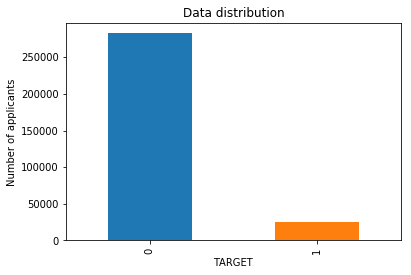

In [10]:
application.groupby("TARGET")['SK_ID_CURR'].count().plot.bar()
plt.title("Data distribution")
plt.ylabel("Number of applicants")

#### Observations
    1. We find that data is highly imbalanced.
    2. We find that more than 250000 applicants didn't pay loan on time whereas on 240000 paid loan on time

### 2.3 Checking for columns where there is no data(Nan)

In [11]:
#missing_values_table(application)
def missing_values(df):
    a=pd.DataFrame(df.isnull().sum(), columns=["missing_values"])
    a["% of missing values"]= np.round((df.isnull().sum()*100)/len(df),2)
    #b=a[a[missing_values]!=0]
    b=a.sort_values("missing_values", ascending=False)
    print("The number of columns with missing values are ",len(b[b["missing_values"]>0]),"out of ",df.shape[1], "columns")
    return b


In [12]:
result=missing_values(application)
print(result.head(10))

The number of columns with missing values are  67 out of  122 columns
                          missing_values  % of missing values
COMMONAREA_MEDI                   214865                69.87
COMMONAREA_AVG                    214865                69.87
COMMONAREA_MODE                   214865                69.87
NONLIVINGAPARTMENTS_MODE          213514                69.43
NONLIVINGAPARTMENTS_AVG           213514                69.43
NONLIVINGAPARTMENTS_MEDI          213514                69.43
FONDKAPREMONT_MODE                210295                68.39
LIVINGAPARTMENTS_MODE             210199                68.35
LIVINGAPARTMENTS_AVG              210199                68.35
LIVINGAPARTMENTS_MEDI             210199                68.35


In [13]:
result=missing_values(previous_application_1)
print(result.head(10))

The number of columns with missing values are  16 out of  37 columns
                           missing_values  % of missing values
RATE_INTEREST_PRIVILEGED          1664263                99.64
RATE_INTEREST_PRIMARY             1664263                99.64
AMT_DOWN_PAYMENT                   895844                53.64
RATE_DOWN_PAYMENT                  895844                53.64
NAME_TYPE_SUITE                    820405                49.12
NFLAG_INSURED_ON_APPROVAL          673065                40.30
DAYS_TERMINATION                   673065                40.30
DAYS_LAST_DUE                      673065                40.30
DAYS_LAST_DUE_1ST_VERSION          673065                40.30
DAYS_FIRST_DUE                     673065                40.30


In [14]:
result=missing_values(bureau_2)
print(result.head(5))

The number of columns with missing values are  7 out of  17 columns
                        missing_values  % of missing values
AMT_ANNUITY                    1226791                71.47
AMT_CREDIT_MAX_OVERDUE         1124488                65.51
DAYS_ENDDATE_FACT               633653                36.92
AMT_CREDIT_SUM_LIMIT            591780                34.48
AMT_CREDIT_SUM_DEBT             257669                15.01


In [15]:
result=missing_values(cash_balance_11)
print(result.head(2))

The number of columns with missing values are  2 out of  8 columns
                       missing_values  % of missing values
CNT_INSTALMENT_FUTURE           26087                 0.26
CNT_INSTALMENT                  26071                 0.26


In [16]:
result= missing_values(installments_12)
print(result.head(2))

The number of columns with missing values are  2 out of  8 columns
                    missing_values  % of missing values
DAYS_ENTRY_PAYMENT            2905                 0.02
AMT_PAYMENT                   2905                 0.02


In [17]:
result= missing_values(credit_card_13)
print(result.head(9))

The number of columns with missing values are  9 out of  23 columns
                            missing_values  % of missing values
AMT_PAYMENT_CURRENT                 767988                20.00
AMT_DRAWINGS_ATM_CURRENT            749816                19.52
CNT_DRAWINGS_POS_CURRENT            749816                19.52
AMT_DRAWINGS_OTHER_CURRENT          749816                19.52
AMT_DRAWINGS_POS_CURRENT            749816                19.52
CNT_DRAWINGS_OTHER_CURRENT          749816                19.52
CNT_DRAWINGS_ATM_CURRENT            749816                19.52
CNT_INSTALMENT_MATURE_CUM           305236                 7.95
AMT_INST_MIN_REGULARITY             305236                 7.95


In [18]:
result= missing_values(bureau_balance_21)
print(result.head(2))

The number of columns with missing values are  0 out of  3 columns
                missing_values  % of missing values
SK_ID_BUREAU                 0                  0.0
MONTHS_BALANCE               0                  0.0


### 2.4 Data types and Number of Unique classes in each categorical Data

In [19]:
def data_type(df):
    print("The types of data present are as follows: ")
    print("="*50)
    print(df.dtypes.value_counts())
    print("="*50)
    print("Number of unique data names in categorical data are: ")
    print("="*50)
    print(df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))


In [20]:
data_type(application)

The types of data present are as follows: 
float64    65
int64      41
object     16
dtype: int64
Number of unique data names in categorical data are: 
NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


In [21]:
data_type(previous_application_1)

The types of data present are as follows: 
object     16
float64    15
int64       6
dtype: int64
Number of unique data names in categorical data are: 
NAME_CONTRACT_TYPE              4
WEEKDAY_APPR_PROCESS_START      7
FLAG_LAST_APPL_PER_CONTRACT     2
NAME_CASH_LOAN_PURPOSE         25
NAME_CONTRACT_STATUS            4
NAME_PAYMENT_TYPE               4
CODE_REJECT_REASON              9
NAME_TYPE_SUITE                 7
NAME_CLIENT_TYPE                4
NAME_GOODS_CATEGORY            28
NAME_PORTFOLIO                  5
NAME_PRODUCT_TYPE               3
CHANNEL_TYPE                    8
NAME_SELLER_INDUSTRY           11
NAME_YIELD_GROUP                5
PRODUCT_COMBINATION            17
dtype: int64


In [22]:
data_type(bureau_2)

The types of data present are as follows: 
float64    8
int64      6
object     3
dtype: int64
Number of unique data names in categorical data are: 
CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64


In [23]:
data_type(cash_balance_11)

The types of data present are as follows: 
int64      5
float64    2
object     1
dtype: int64
Number of unique data names in categorical data are: 
NAME_CONTRACT_STATUS    9
dtype: int64


In [24]:
data_type(installments_12)

The types of data present are as follows: 
float64    5
int64      3
dtype: int64
Number of unique data names in categorical data are: 
Series([], dtype: float64)


In [25]:
data_type(credit_card_13)

The types of data present are as follows: 
float64    15
int64       7
object      1
dtype: int64
Number of unique data names in categorical data are: 
NAME_CONTRACT_STATUS    7
dtype: int64


In [26]:
data_type(bureau_balance_21)

The types of data present are as follows: 
int64     2
object    1
dtype: int64
Number of unique data names in categorical data are: 
STATUS    8
dtype: int64


### Note:
    1. As there are several sources of data with multiple columns, We analyse each source of data one at a time.
    2. We will merge all the important features into a dataframe and run our machine learning models on this dataframe.
    3. We are doing this to avoid confusion and to anaylse the data thoroughly.
    4. Before proceeding further, We split the data into train,test and CV.
    5. We'll work on preprocessing train data and apply these changes to test and cv using imputer tool from scikit learn.

## 3 Splitting the data into train, test and cross-validation

In [53]:
from sklearn.model_selection import train_test_split
y= application["TARGET"]
application1= application.drop(["TARGET"],axis=1)
X_train1,X_test, y_train1, Y_test = train_test_split(application1, y, stratify=y, test_size=0.10)
X_train,X_cv, Y_train, Y_cv = train_test_split(X_train1, y_train1, stratify=y_train1, test_size=0.11111)

print("the shape of train data is {} and labels is {} ".format(X_train.shape,len(Y_train)))
print("the shape of cv data is {} and labels is {}".format(X_cv.shape,len(Y_cv)))
print("the shape of test data is {} and labels is {}".format(X_test.shape,len(Y_test)))
print("="*60)
a=Y_train.mean()*100
print("the percentage of loan defaulters in train data is ",np.round(a,2),"%" )
b=Y_cv.mean()*100
print("the percentage loan defaulters in CV data is ",np.round(b,2),"%" )
c=Y_test.mean()*100
print("the percentage of loan defaulters in test data is ",np.round(c,2),"%" )


the shape of train data is (246008, 121) and labels is 246008 
the shape of cv data is (30751, 121) and labels is 30751
the shape of test data is (30752, 121) and labels is 30752
the percentage of loan defaulters in train data is  8.07 %
the percentage loan defaulters in CV data is  8.07 %
the percentage of loan defaulters in test data is  8.07 %


## 4 Feature extraction from  Application Data

### 4.1 Encoding the data
    We Will encode data with unique labels greater than 3 as one hot encoding to prevent any arbritrary ordering.

In [54]:
X_train = pd.get_dummies(X_train)
X_cv = pd.get_dummies(X_cv)
X_test=pd.get_dummies(X_test)

print('The shape of train data after one hot encoding: ', X_train.shape)
print('The shape of cv data after one hot encoding:: ', X_cv.shape)
print('The shape of test data after one hot encoding:: ', X_test.shape)

The shape of train data after one hot encoding:  (246008, 245)
The shape of cv data after one hot encoding::  (30751, 245)
The shape of test data after one hot encoding::  (30752, 242)


#### Note:    
    1. We find that the cv and test data may not have all the categorical variables or there may be new categorical variables
       introduced.
    2. It's highly likely that the data may be misaligned.
    3. To run our machine learning models, We will have to align the data
    4. So, we'll remove the data that is not present in cv and test data

### 4.2 Aligning The Data

In [55]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.align.html

# Align the training and testing data, keep only columns present in both dataframes
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
X_cv, X_test = X_cv.align(X_test, join = 'inner', axis = 1)

print(" The shape of train data after alignment is ", X_train.shape,"and length target train is ", len(Y_train) )
print(" The shape of cv data after alignment is ", X_cv.shape,"and length target train is ", len(Y_cv)  )
print(" The shape of test data after alignment is ", X_test.shape,"and length target train is ", len(Y_test)  )

 The shape of train data after alignment is  (246008, 242) and length target train is  246008
 The shape of cv data after alignment is  (30751, 242) and length target train is  30751
 The shape of test data after alignment is  (30752, 242) and length target train is  30752


In [60]:
X_train["TARGET"]=Y_train 
X_train.head(1)

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
183205      312343             1          117000.0    601470.0      30708.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
183205         450000.0                    0.035792      -13903   

        DAYS_EMPLOYED  DAYS_REGISTRATION   ...    WALLSMATERIAL_MODE_Block  \
183205          -1603             -163.0   ...                           0   

        WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
183205                         0                              0   

        WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
183205                          0                         0   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
183205                                0                          0   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  TARGET  
183205                       0                        0       0  

[1 rows x 243 columns]

In [61]:
X_cv["TARGET"]=Y_cv 
X_cv.head(1)

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
242756      381007             0          225000.0   1051245.0      30865.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
242756         877500.0                    0.019689      -16080   

        DAYS_EMPLOYED  DAYS_REGISTRATION   ...    WALLSMATERIAL_MODE_Block  \
242756           -583            -3254.0   ...                           0   

        WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
242756                         0                              0   

        WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
242756                          0                         0   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
242756                                0                          0   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  TARGET  
242756                       0                        0       0  

[1 rows x 243 columns]

In [62]:
X_test["TARGET"]=Y_test 
X_test.head(1)

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
16781      119568             0          177750.0    924394.5      30681.0   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
16781         702000.0                    0.016612      -16112          -8573   

       DAYS_REGISTRATION   ...    WALLSMATERIAL_MODE_Block  \
16781            -8560.0   ...                           0   

       WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
16781                         0                              0   

       WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
16781                          0                         0   

       WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
16781                                0                          0   

       EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  TARGET  
16781                       0                        0       0  

[1 rows x 243 columns]

### 4.3 Exploratory Data Analysis
    We shall look for outliers in the data we have. For this We shall describe funtion and boxplot to get some 
    valauble information about the data.

#### Days of employment

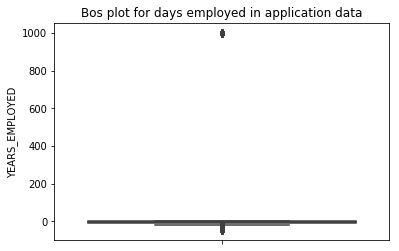

count    246008.000000
mean        174.955927
std         387.160222
min         -49.073973
25%          -7.572603
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: YEARS_EMPLOYED, dtype: float64


In [63]:
X1_train=pd.DataFrame()
X1_train["DAYS_EMPLOYED"]= X_train["DAYS_EMPLOYED"]
X1_train["YEARS_EMPLOYED"]=X1_train["DAYS_EMPLOYED"]/365
sns.boxplot(y="YEARS_EMPLOYED",data=X1_train)
plt.title("Bos plot for days employed in application data")
plt.show()
print(X1_train['YEARS_EMPLOYED'].describe())

#### Observation
    1. We find some outliers here. We need explore the data a bit more to understand it.
    2. We find years employed is 1000 which is not possible.
    3. While the rest of the data is negative,maxiumum value appears to be positive.
    4. We also find that the outlier appears multiple times in the data with same value 365243.
    4. Before removing these anamolies, We'll see if they are related to defaulting loan 

In [64]:
X2_train= X_train
X2_train["TARGET"]=y
outlier = X2_train[X2_train['DAYS_EMPLOYED'] == 365243]
non_outlier = X2_train[X2_train['DAYS_EMPLOYED'] != 365243]
print('There are %d anomalous days of employment' % len(outlier))
print('The outliers default on %0.2f%% of loans' % (100 * outlier['TARGET'].mean()))
print('The Non outliers default on %0.2f%% of loans' % (100 * non_outlier['TARGET'].mean()))


There are 44329 anomalous days of employment
The outliers default on 5.41% of loans
The Non outliers default on 8.66% of loans


We find that the data is somehow related. For the time being we keep the anomalous data as boolean data and modify it depending on future analysis

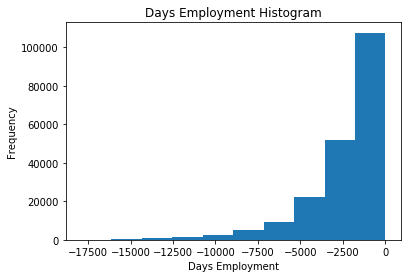

In [65]:
# Create an anomalous flag column
X_train['DAYS_EMPLOYED_OUTLIER'] = X_train["DAYS_EMPLOYED"] == 365243
X_cv['DAYS_EMPLOYED_OUTLIER'] = X_cv["DAYS_EMPLOYED"] == 365243
X_test['DAYS_EMPLOYED_OUTLIER'] = X_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
X_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
X_cv['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
X_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

X_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');
plt.ylabel('Frequency')
plt.show()

#### Observation
    1. We find that majority of days of employment are in the range 0-2500

#### Days for registration

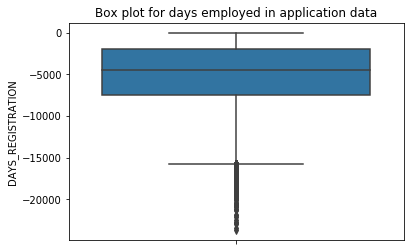

count    246008.000000
mean      -4989.983684
std        3527.155862
min      -23738.000000
25%       -7492.000000
50%       -4504.000000
75%       -2009.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64


In [66]:
X1_train["DAYS_REGISTRATION"]= X_train["DAYS_REGISTRATION"]
#X1_train["DAYS_REGISTRATION"]=X1_train["DAYS_REGISTRATION"]/365
sns.boxplot(y="DAYS_REGISTRATION",data=X1_train)
plt.title("Box plot for days employed in application data")
plt.show()
print(X_train['DAYS_REGISTRATION'].describe())

#### Observation
    1. We find that the data has not outliers.

#### Number of children for each applicant

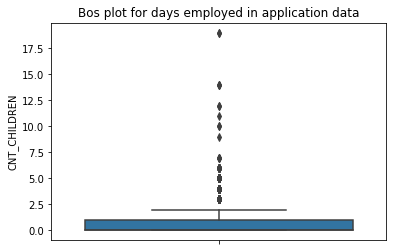

count    246008.000000
mean          0.417986
std           0.723254
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
The number of applicants with more than 8 children are:  11


In [67]:
X1_train["CNT_CHILDREN"]= X_train["CNT_CHILDREN"]
sns.boxplot(y="CNT_CHILDREN",data=X1_train)
plt.title("Bos plot for days employed in application data")
plt.show()
print(X_train['CNT_CHILDREN'].describe())
print("="*100)
print("The number of applicants with more than 8 children are: ",len(X_train[X_train["CNT_CHILDREN"]>8]))

#### Observations
    1. 75% of the people have less than 2 children. 
    2. We shall count the outliers for more than 8 children.
    3. We shall remove these outliers

In [68]:
X_train= X_train[X_train["CNT_CHILDREN"]<8]
print("the shape of train data is ",X_train.shape)

the shape of train data is  (245997, 244)


#### Age of applicant

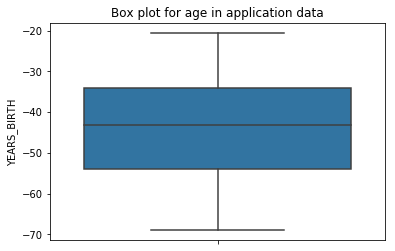

count    245997.000000
mean        -43.941732
std          11.951844
min         -69.032877
25%         -53.926027
50%         -43.161644
75%         -34.021918
max         -20.517808
Name: YEARS_BIRTH, dtype: float64


In [69]:
X1_train["DAYS_BIRTH"]= X_train["DAYS_BIRTH"]
X1_train["YEARS_BIRTH"]=X1_train["DAYS_BIRTH"]/365
sns.boxplot(y="YEARS_BIRTH",data=X1_train)
plt.title("Box plot for age in application data")
plt.show()
print(X1_train['YEARS_BIRTH'].describe())

#### Observations:
    1. Data seems okay with no outliers.

#### We find that the rest of the application data is either labelled or normalised. So, There won't be further possibilities to detect outliers visually.

### 4.4 Correlation

- http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf
- https://www.investopedia.com/terms/c/correlationcoefficient.asp
  
   Refer the links for more info. The following range of pearson correlation coefficents suggest the following:
        1) .00-.19 “very weak”
        2) .20-.39 “weak”
        3) .40-.59 “moderate”
        4) .60-.79 “strong”
        5) .80-1.0 “very strong”


In [70]:
# Find correlations with the target and sort
correlations = X_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(10))
print("="*50)
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 DAYS_ID_PUBLISH                0.052191
CODE_GENDER_M                  0.054912
DAYS_LAST_PHONE_CHANGE         0.056641
NAME_INCOME_TYPE_Working       0.057777
REGION_RATING_CLIENT           0.058737
REGION_RATING_CLIENT_W_CITY    0.060737
DAYS_EMPLOYED                  0.075137
DAYS_BIRTH                     0.078129
TARGET                         1.000000
FLAG_MOBIL                          NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178751
EXT_SOURCE_2                           -0.161728
EXT_SOURCE_1                           -0.156152
NAME_EDUCATION_TYPE_Higher education   -0.058235
CODE_GENDER_F                          -0.054907
NAME_INCOME_TYPE_Pensioner             -0.046064
ORGANIZATION_TYPE_XNA                  -0.045789
DAYS_EMPLOYED_OUTLIER                  -0.045789
FLOORSMAX_AVG                          -0.045053
FLOORSMAX_MEDI                         -0.044801
Name: TARGET, dtype: f

#### observations
    1. We find that the most correlated feature is days_birth. 
    2. It says that the younger the age, the higher the possiblity of defaulting the loan.
    3. But as we know that days are negative integer in the column, We have misinterpreted observation 2.
    4. It says the lower the negative value of age, the higher the possiblity of defaulting the loan.
    5. This actually means higher the absolute value of age, lower is the possibility of defaulting the loan.
    6. This could mean that the bank can take precautionary measures against young applicants as they have higher chances
       of defualting the loan.
    7. We'll work on the negatively correlated data as they are of higher significance.
    8. We find that ext source 1,2 and 3 are most negatively correlated.
    9. Since these features are normalised, we don't have much info on it.
    10.For further data analysis, We'll consider external source 1,2 and 3 and days_birth. 

### 4.5 EDA on extracted Data

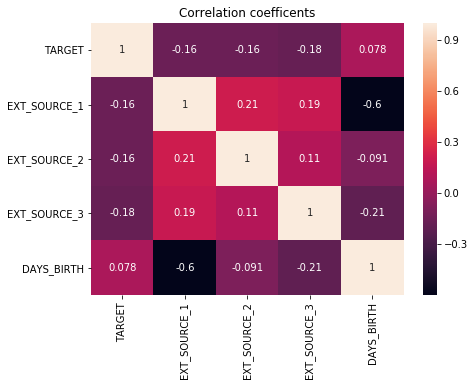

In [71]:
extracted_data = X_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
extracted_correlation = extracted_data.corr()
plt.figure(figsize=(7,5))
sns.heatmap(extracted_correlation, annot= True)
plt.title("Correlation coefficents")
plt.show()

#### Observation
    1. We find that days of birth and ext source are quite correlated.

### Pair plot for extracted data

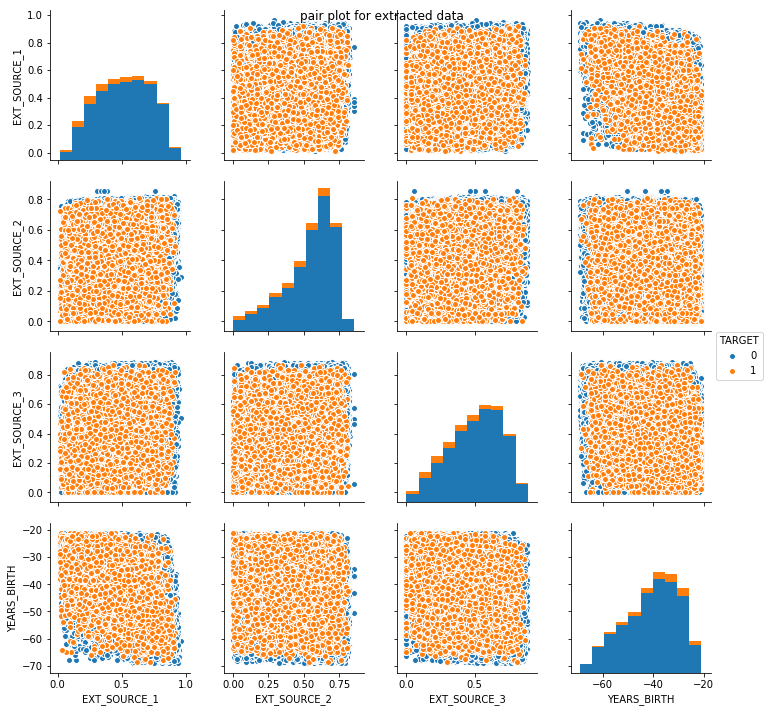

In [72]:
n = extracted_data.shape[0]
#print(n)
extracted_data1= extracted_data.dropna()
extracted_data1["YEARS_BIRTH"]=extracted_data["DAYS_BIRTH"]/365
sns.pairplot(extracted_data1[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BIRTH']][0:n], hue='TARGET', vars=[ 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BIRTH'])
plt.suptitle("pair plot for extracted data")
plt.show()

#### Observations
    1. It's hard to understand the data using pair plot. we shall use pair grid from sns.

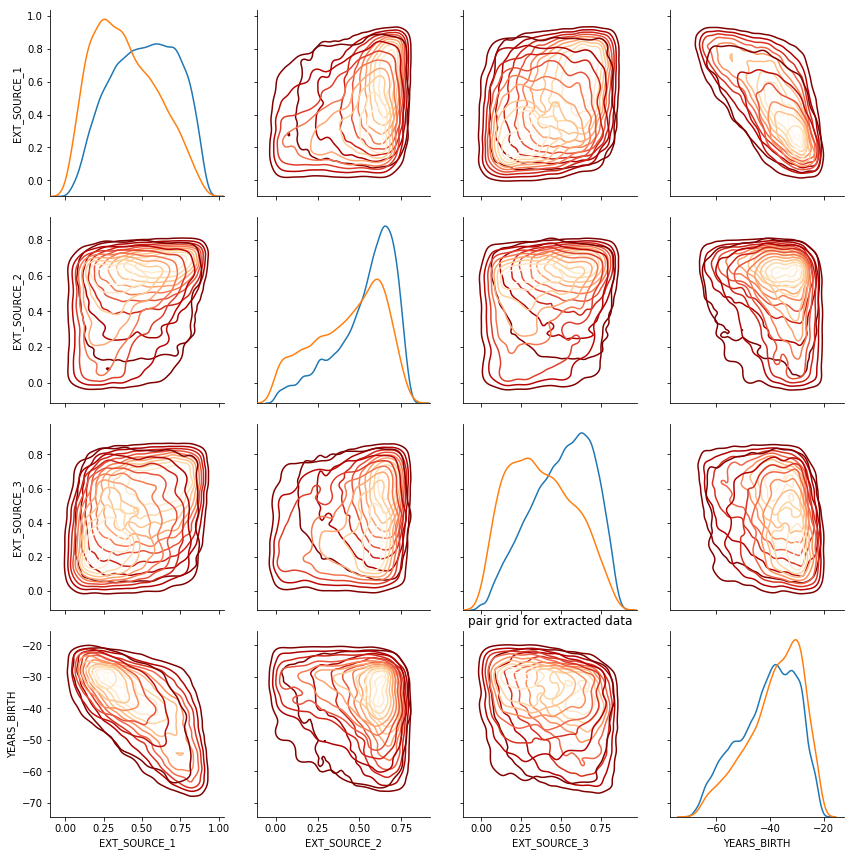

In [52]:
import warnings 
warnings.filterwarnings("ignore") 
#extracted_data1= extracted_data1.drop(["DAYS_BIRTH"],axis=1)
sns.PairGrid(data = extracted_data1, size = 3, diag_sharey=False,hue = 'TARGET', vars = [x for x in list(extracted_data1) if x != 'TARGET']).map_upper(sns.kdeplot, cmap = plt.cm.OrRd_r).map_diag(sns.kdeplot).map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
plt.title("pair grid for extracted data")
plt.show()


#### Observation
    1. As seen above, We find that years_birth and exernal source 1 are correlated.
    2. Clearly these plots are more understandable

### 4.6 Feature engineering on Extracted Data

#### Imputing missing values and checking for Polynomial features

In [73]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
# Make a new dataframe for polynomial features
polynomial_train = X_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',"TARGET"]]
polynomial_cv= X_cv[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
polynomial_test = X_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
import warnings
warnings.filterwarnings("ignore")
#for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

polynomial_target = polynomial_train['TARGET']

polynomial_train = polynomial_train.drop(columns = ['TARGET'])

# Need to impute missing values
imputer.fit(polynomial_train)
polynomial_train =imputer.transform(polynomial_train)
polynomial_cv = imputer.transform(polynomial_cv)
polynomial_test= imputer.transform(polynomial_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly = PolynomialFeatures(degree = 3)
poly.fit(polynomial_train)
polynomial_train = poly.transform(polynomial_train)
polynomial_cv = poly.transform(polynomial_cv)
polynomial_test = poly.transform(polynomial_test)
print('Polynomial Features shape of train data: ', polynomial_train.shape)
print('Polynomial Features shape of cv data  ', polynomial_cv.shape)
print('Polynomial Features shape of test data ', polynomial_test.shape)

Polynomial Features shape of train data:  (245997, 35)
Polynomial Features shape of cv data   (30751, 35)
Polynomial Features shape of test data  (30752, 35)


In [74]:
polynomial_train1= pd.DataFrame(polynomial_train, columns=poly.get_feature_names\
                                (['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
polynomial_train1["TARGET"]=polynomial_target
polynomial_train1.head(2)

1  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  EXT_SOURCE_1^2  \
0  1.0      0.506408      0.338254      0.535276    -13903.0        0.256449   
1  1.0      0.506408      0.671667      0.535276    -18541.0        0.256449   

   EXT_SOURCE_1 EXT_SOURCE_2  EXT_SOURCE_1 EXT_SOURCE_3  \
0                   0.171294                   0.271068   
1                   0.340137                   0.271068   

   EXT_SOURCE_1 DAYS_BIRTH  EXT_SOURCE_2^2   ...    \
0             -7040.587640        0.114415   ...     
1             -9389.307015        0.451136   ...     

   EXT_SOURCE_2^2 EXT_SOURCE_3  EXT_SOURCE_2^2 DAYS_BIRTH  \
0                     0.061244               -1590.718224   
1                     0.241483               -8364.518328   

   EXT_SOURCE_2 EXT_SOURCE_3^2  EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH  \
0                     0.096917                          -2517.264577   
1                     0.192446                          -6665.995562   

   EXT_SOURCE_2 DAYS_BIRTH^2  EXT_SOURCE_3^3  EXT_SOURCE_3^2 DAYS_BIRTH  \
0               6.538218e+07        0.153368               -3983.496796   
1               2.308980e+08        0.153368               -5312.379637   

   EXT_SOURCE_3 DAYS_BIRTH^2  DAYS_BIRTH^3  TARGET  
0               1.034654e+08 -2.687358e+12     1.0  
1               1.840112e+08 -6.373815e+12     0.0  

[2 rows x 36 columns]

#### Correlation of polynomial features

In [75]:
polynomial_correlation = polynomial_train1.corr()['TARGET'].sort_values()

# Display most negative and most positive
print("The positive correlated coefficents are: ")
print(polynomial_correlation.head(5))
print("="*50)
print("The positive correlated coefficents are: ")
print(polynomial_correlation.tail(5))

The positive correlated coefficents are: 
EXT_SOURCE_2 EXT_SOURCE_3     -0.002995
EXT_SOURCE_2^2 EXT_SOURCE_3   -0.002897
EXT_SOURCE_2 EXT_SOURCE_3^2   -0.002876
EXT_SOURCE_2                  -0.002766
EXT_SOURCE_2^2                -0.002759
Name: TARGET, dtype: float64
The positive correlated coefficents are: 
EXT_SOURCE_1                            0.002270
EXT_SOURCE_1^2                          0.002320
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.002355
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


#### Observation
    1. We find that polynomial features are not very useful
    2. Hence We shall not use them.

#### Domain features

- https://www.kaggle.com/c/home-credit-default-risk/discussion

- (https://www.investopedia.com/terms/i/income_annuity.asp)
- (https://www.investopedia.com/terms/e/earnedincomecredit.asp)
- (https://www.accountingtools.com/articles/2017/5/15/credit-terms-and-the-cost-of-credit)
- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [76]:
X_train_check = X_train.copy()
X_cv_check = X_cv.copy()
X_test_check = X_test.copy()

X_train_check['CREDIT_INCOME_PERCENT'] = X_train_check['AMT_CREDIT'] / X_train_check['AMT_INCOME_TOTAL']
X_train_check['ANNUITY_INCOME_PERCENT'] = X_train_check['AMT_ANNUITY'] / X_train_check['AMT_INCOME_TOTAL']
X_train_check['CREDIT_TERM'] = X_train_check['AMT_ANNUITY'] / X_train_check['AMT_CREDIT']
X_train_check['DAYS_EMPLOYED_PERCENT'] = X_train_check['DAYS_EMPLOYED'] / X_train_check['DAYS_BIRTH']

X_cv_check['CREDIT_INCOME_PERCENT'] = X_cv_check['AMT_CREDIT'] / X_cv_check['AMT_INCOME_TOTAL']
X_cv_check['ANNUITY_INCOME_PERCENT'] = X_cv_check['AMT_ANNUITY'] / X_cv_check['AMT_INCOME_TOTAL']
X_cv_check['CREDIT_TERM'] = X_cv_check['AMT_ANNUITY'] / X_cv_check['AMT_CREDIT']
X_cv_check['DAYS_EMPLOYED_PERCENT'] = X_cv_check['DAYS_EMPLOYED'] / X_cv_check['DAYS_BIRTH']

X_test_check['CREDIT_INCOME_PERCENT'] = X_test_check['AMT_CREDIT'] / X_test_check['AMT_INCOME_TOTAL']
X_test_check['ANNUITY_INCOME_PERCENT'] = X_test_check['AMT_ANNUITY'] / X_test_check['AMT_INCOME_TOTAL']
X_test_check['CREDIT_TERM'] = X_test_check['AMT_ANNUITY'] / X_test_check['AMT_CREDIT']
X_test_check['DAYS_EMPLOYED_PERCENT'] = X_test_check['DAYS_EMPLOYED'] / X_test_check['DAYS_BIRTH']

print("The shape of train data is ",X_train_check.shape)
print("The shape of cv data is ",X_cv_check.shape)
print("The shape of test data is ",X_test_check.shape)

The shape of train data is  (245997, 248)
The shape of cv data is  (30751, 248)
The shape of test data is  (30752, 248)


In [77]:
X_train_check.head(2)

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
183205      312343             1          117000.0    601470.0      30708.0   
100626      216830             0           83250.0    432220.5      30082.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
183205         450000.0                    0.035792      -13903   
100626         400500.0                    0.026392      -18541   

        DAYS_EMPLOYED  DAYS_REGISTRATION          ...            \
183205        -1603.0             -163.0          ...             
100626            NaN           -12216.0          ...             

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
183205                                0                          0   
100626                                0                          0   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  TARGET  \
183205                       0                        0       0   
100626                       0                        0       0   

        DAYS_EMPLOYED_OUTLIER  CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  \
183205                  False               5.140769                0.262462   
100626                   True               5.191838                0.361351   

        CREDIT_TERM  DAYS_EMPLOYED_PERCENT  
183205     0.051055               0.115299  
100626     0.069600                    NaN  

[2 rows x 248 columns]

<Figure size 720x360 with 0 Axes>

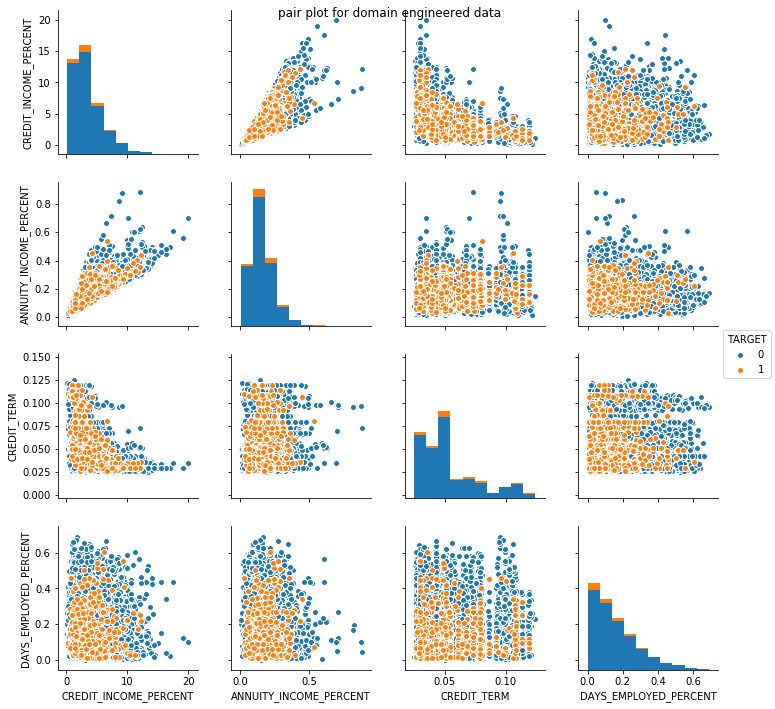

In [78]:
n = X_train_check.shape[0]
X_train_check1=X_train_check.dropna()
plt.figure(figsize=(10,5))
sns.pairplot(X_train_check1[['TARGET', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']][0:n], hue='TARGET', vars=['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT'])
plt.suptitle("pair plot for domain engineered data")
plt.show()

#### Observations
    1. We find that the features are separable to some extent. 
    2. This tells us that data will be quite useful for out machine learning models

## 5 Feature Extraction from Bureau Data

- bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
- bureau_balance: monthly information about the previous loans. Each month has its own row.

### 5.1 Loan application count for each applicant from other institutions
 We will count the previous applications for clients at other institutions and append it to the application data

In [79]:
bureau_2.head(2)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN

In [80]:
previous_app_counts = bureau_2.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_app_counts'})
X_train_check = X_train_check.merge(previous_app_counts, on = 'SK_ID_CURR', how = 'left')
X_test_check = X_test_check.merge(previous_app_counts, on = 'SK_ID_CURR', how = 'left')
X_cv_check = X_cv_check.merge(previous_app_counts, on = 'SK_ID_CURR', how = 'left')
X_train_check['previous_app_counts'] = X_train_check['previous_app_counts'].fillna(0)
X_test_check['previous_app_counts'] = X_test_check['previous_app_counts'].fillna(0)
X_cv_check['previous_app_counts'] = X_cv_check['previous_app_counts'].fillna(0)
print('The shape of training data is : ', X_train_check.shape)
print('The shape of cv data is ',X_cv_check.shape)
print('The shape of testing data: ', X_test_check.shape)

The shape of training data is :  (245997, 249)
The shape of cv data is  (30751, 249)
The shape of testing data:  (30752, 249)


#### EDA on Number of applications

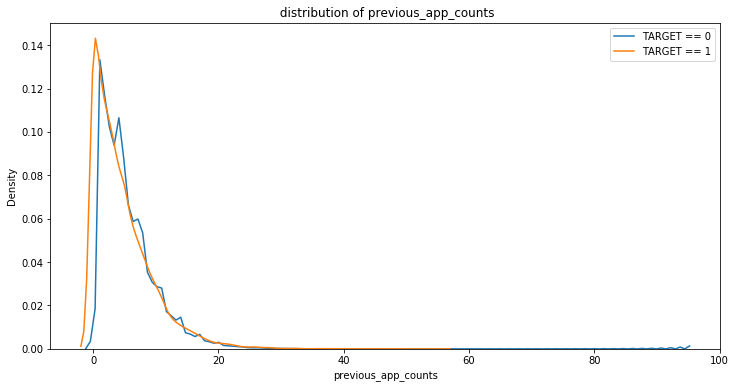

In [81]:
#https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 0, "previous_app_counts"], label = 'TARGET == 0')
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 1, "previous_app_counts"], label = 'TARGET == 1')
plt.xlabel("previous_app_counts"); plt.ylabel('Density'); plt.title(" distribution of previous_app_counts")
plt.legend()
plt.show()


#### Observations
    1. We find that the people who default the loan have significantly no previous loan applications

### 5.2 Aggregating numerical data for each applicant 

In [82]:
#https://stackoverflow.com/questions/23410083/pandas-multiple-columns-into-one-column
#https://stackoverflow.com/questions/40410867/python-pandas-dataframe-aggregate-groupby?rq=1
bureau_aggregate = bureau_2.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False)\
                            .agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
columns = ['SK_ID_CURR']

for var in bureau_aggregate.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in bureau_aggregate.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))
bureau_aggregate.columns = columns
bureau_aggregate.head(3)            

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7                  -735.00   
1      100002                         8                  -874.00   
2      100003                         4                 -1400.75   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  \
0                              0                              0   
1                              0                              0   
2                              0                              0   

            ...            bureau_DAYS_CREDIT_UPDATE_count  \
0           ...                                          7   
1           ...                                          8   
2           ...                                          4   

   bureau_DAYS_CREDIT_UPDATE_mean  bureau_DAYS_CREDIT_UPDATE_max  \
0                      -93.142857                             -6   
1                     -499.875000                             -7   
2                     -816.000000                            -43   

   bureau_DAYS_CREDIT_UPDATE_min  bureau_DAYS_CREDIT_UPDATE_sum  \
0                           -155                           -652   
1                          -1185                          -3999   
2                          -2131                          -3264   

   bureau_AMT_ANNUITY_count  bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  \
0                         7              3545.357143                 10822.5   
1                         7                 0.000000                     0.0   
2                         0                      NaN                     NaN   

   bureau_AMT_ANNUITY_min  bureau_AMT_ANNUITY_sum  
0                     0.0                 24817.5  
1                     0.0                     0.0  
2                     NaN                     0.0  

[3 rows x 61 columns]

In [83]:
X_train_check = X_train_check.merge(bureau_aggregate, on = 'SK_ID_CURR', how = 'left')
X_cv_check = X_cv_check.merge(bureau_aggregate, on = 'SK_ID_CURR', how = 'left')
X_test_check = X_test_check.merge(bureau_aggregate, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check.shape)
print('The shape of cv data is ',X_cv_check.shape)
print('The shape of testing data: ', X_test_check.shape)

The shape of training data is :  (245997, 309)
The shape of cv data is  (30751, 309)
The shape of testing data:  (30752, 309)


#### EDA on Aggregated data

In [84]:
agg_correlation = []

# Iterate through the columns 
for column in columns:
    # Calculate correlation with the target
    correlation = X_train_check['TARGET'].corr(X_train_check[column])
    agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The coreelation values obtained are as follows:")
agg_correlation[:15]    

The coreelation values obtained are as follows:


[('bureau_DAYS_CREDIT_mean', 0.08854488405934877),
 ('bureau_DAYS_CREDIT_min', 0.07472511494902499),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06799302406325068),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.056256256730169554),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05358350585693373),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05285136732787845),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04911541427652139),
 ('bureau_DAYS_CREDIT_max', 0.047729096064507676),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046005253502388134),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04441888515436639),
 ('bureau_DAYS_CREDIT_sum', 0.04200750944494954),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04188530684170807),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03617665922837249),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03381285683842058),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030356707671015448)]

#### Observations
    1. The values doesn't seem of much significance.
    2. We shall consider and explore more on top features here

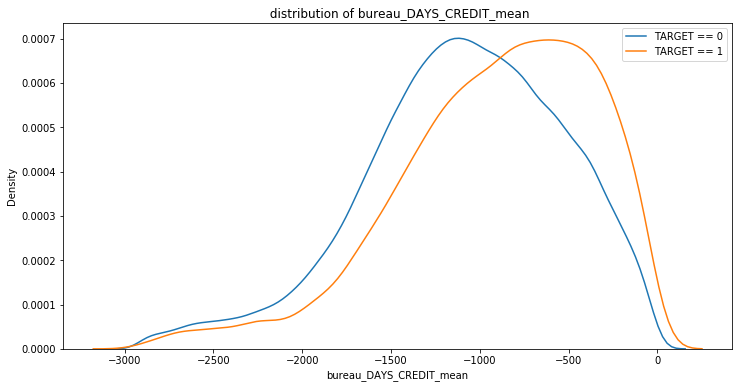

In [85]:
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 0, "bureau_DAYS_CREDIT_mean"], label = 'TARGET == 0')
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 1, "bureau_DAYS_CREDIT_mean"], label = 'TARGET == 1')
plt.xlabel("bureau_DAYS_CREDIT_mean"); plt.ylabel('Density'); plt.title(" distribution of bureau_DAYS_CREDIT_mean")
plt.legend()
plt.show()


#### Observation
    1. We find that the data the is distribution is a bit different for both.
    2. The people who defaulted loans seem to have higher negative mean credit than those who didn't default.

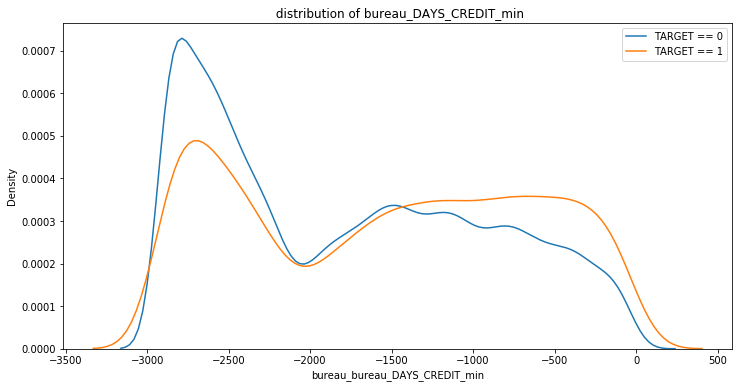

In [86]:
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 0, "bureau_DAYS_CREDIT_min"], label = 'TARGET == 0')
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 1, "bureau_DAYS_CREDIT_min"], label = 'TARGET == 1')
plt.xlabel("bureau_bureau_DAYS_CREDIT_min"); plt.ylabel('Density'); plt.title(" distribution of bureau_DAYS_CREDIT_min")
plt.legend()
plt.show()

#### Observations
    1. The feature doesn't distinguish the target labels much.

### 5.3 Extracting features from categorical variables
- We shall one hot encode the categorical data in bureau first
- Later We'll Aggregate these counts and append it to the train data

In [87]:
categorical_data = pd.get_dummies(bureau_2.select_dtypes('object'))
categorical_data['SK_ID_CURR'] = bureau_2['SK_ID_CURR']
categorical_grouped = categorical_data.groupby('SK_ID_CURR', as_index=False).agg(['sum', 'mean']).reset_index()

group_var = 'SK_ID_CURR'

# Need to create new column names
columns = ['SK_ID_CURR']
#categorical_id= categorical_grouped['SK_ID_CURR']
#categorical_grouped=categorical_grouped.drop(['SK_ID_CURR'], axis=1)
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in categorical_grouped.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

categorical_grouped.columns = columns          
categorical_grouped.head(2)
   #  Rename the columns


SK_ID_CURR  CREDIT_ACTIVE_Active_sum  CREDIT_ACTIVE_Active_mean  \
0      100001                         3                   0.428571   
1      100002                         2                   0.250000   

   CREDIT_ACTIVE_Bad debt_sum  CREDIT_ACTIVE_Bad debt_mean  \
0                           0                          0.0   
1                           0                          0.0   

   CREDIT_ACTIVE_Closed_sum  CREDIT_ACTIVE_Closed_mean  \
0                         4                   0.571429   
1                         6                   0.750000   

   CREDIT_ACTIVE_Sold_sum  CREDIT_ACTIVE_Sold_mean  \
0                       0                      0.0   
1                       0                      0.0   

   CREDIT_CURRENCY_currency 1_sum                  ...                    \
0                               7                  ...                     
1                               8                  ...                     

   CREDIT_TYPE_Microloan_sum  CREDIT_TYPE_Microloan_mean  \
0                          0                         0.0   
1                          0                         0.0   

   CREDIT_TYPE_Mobile operator loan_sum  \
0                                     0   
1                                     0   

   CREDIT_TYPE_Mobile operator loan_mean  CREDIT_TYPE_Mortgage_sum  \
0                                    0.0                         0   
1                                    0.0                         0   

   CREDIT_TYPE_Mortgage_mean  CREDIT_TYPE_Real estate loan_sum  \
0                        0.0                                 0   
1                        0.0                                 0   

   CREDIT_TYPE_Real estate loan_mean  CREDIT_TYPE_Unknown type of loan_sum  \
0                                0.0                                     0   
1                                0.0                                     0   

   CREDIT_TYPE_Unknown type of loan_mean  
0                                    0.0  
1                                    0.0  

[2 rows x 47 columns]

In [88]:
X_train_check = X_train_check.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')
X_cv_check = X_cv_check.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')
X_test_check = X_test_check.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check.shape)
print('The shape of cv data is ',X_cv_check.shape)
print('The shape of testing data: ', X_test_check.shape)

The shape of training data is :  (245997, 355)
The shape of cv data is  (30751, 355)
The shape of testing data:  (30752, 355)


#### EDA on Categorical data

In [89]:
grouped_correlation = []

# Iterate through the columns 
for column in columns:
    # Calculate correlation with the target
    correlation = X_train_check['TARGET'].corr(X_train_check[column])
    grouped_correlation.append((column, correlation))
grouped_correlation = sorted(grouped_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The correlation values obtained are as follows:")
grouped_correlation[:15] 

The correlation values obtained are as follows:


[('CREDIT_ACTIVE_Closed_mean', -0.07848774775485673),
 ('CREDIT_ACTIVE_Active_mean', 0.07626330388194158),
 ('CREDIT_ACTIVE_Active_sum', 0.06803799094946793),
 ('CREDIT_TYPE_Microloan_mean', 0.045948295027080435),
 ('CREDIT_TYPE_Microloan_sum', 0.03916761875254804),
 ('CREDIT_TYPE_Credit card_sum', 0.03426460372529125),
 ('CREDIT_TYPE_Credit card_mean', 0.03344593087511871),
 ('CREDIT_ACTIVE_Closed_sum', -0.030693360924503543),
 ('CREDIT_TYPE_Consumer credit_mean', -0.02530757608287301),
 ('CREDIT_TYPE_Car loan_mean', -0.022119934954767887),
 ('CREDIT_TYPE_Car loan_sum', -0.022104886699122517),
 ('CREDIT_ACTIVE_Sold_mean', 0.017932978424649224),
 ('CREDIT_ACTIVE_Sold_sum', 0.013177491704438405),
 ('CREDIT_TYPE_Consumer credit_sum', -0.010184451897514862),
 ('CREDIT_CURRENCY_currency 1_mean', 0.0071516232756782365)]

#### Observation
    1. We will explore more on top 2 correlated features.

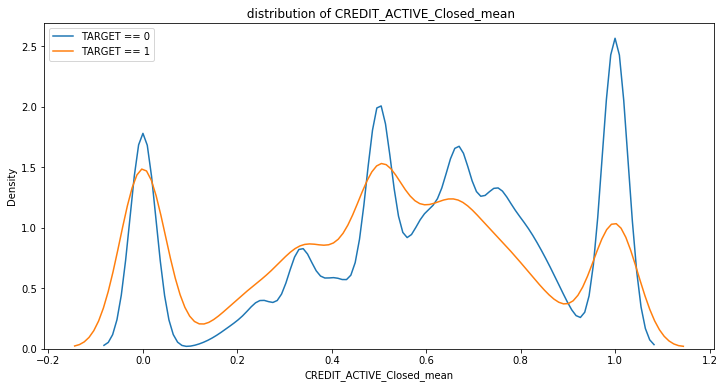

In [90]:
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 0, "CREDIT_ACTIVE_Closed_mean"], label = 'TARGET == 0')
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 1, "CREDIT_ACTIVE_Closed_mean"], label = 'TARGET == 1')
plt.xlabel("CREDIT_ACTIVE_Closed_mean"); plt.ylabel('Density'); plt.title(" distribution of CREDIT_ACTIVE_Closed_mean")
plt.legend()
plt.show()

#### Observation
    1. We don't see any pattern in this data

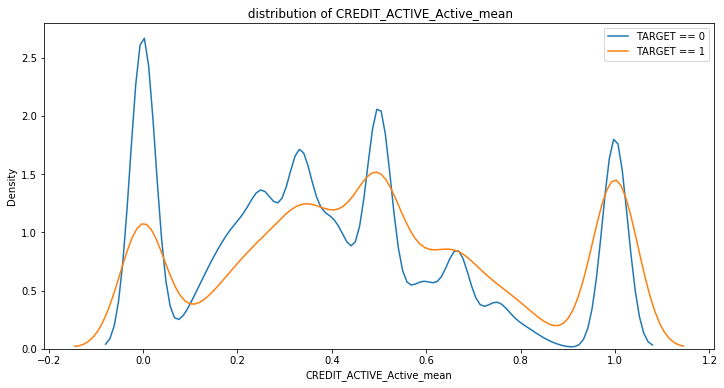

In [91]:
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 0, "CREDIT_ACTIVE_Active_mean"], label = 'TARGET == 0')
sns.kdeplot(X_train_check.ix[X_train_check['TARGET'] == 1, "CREDIT_ACTIVE_Active_mean"], label = 'TARGET == 1')
plt.xlabel("CREDIT_ACTIVE_Active_mean"); plt.ylabel('Density'); plt.title(" distribution of CREDIT_ACTIVE_Active_mean")
plt.legend()
plt.show()

#### Observations
1. It's hard to tell anything if data will be useful as of now.

### 5.4 Optimising the extracted features
- For each of step of feature extraction, we shall discard columns with missing information by tuning certain threshold
- We shall remove highly collinear features 
- We are doing to prevent overfitting of the data

#### Removing columns with missing information greater than 70%

In [6]:
def column_optimization(train, test,cv, threshold = 70):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_1 = pd.DataFrame(train.isnull().sum())
    train_1['percent'] = 100 * train_1[0] / len(train)
    
    test_1 = pd.DataFrame(test.isnull().sum())
    test_1['percent'] = 100 * test_1[0] / len(test)

    cv_1 = pd.DataFrame(cv.isnull().sum())
    cv_1['percent'] = 100 * cv_1[0] / len(test)
    
    
    # list of missing columns for train and test
    train_2 = list(train_1.index[train_1['percent'] > threshold])
    test_2  = list(test_1.index[test_1['percent'] > threshold])
    cv_2    = list(cv_1.index[cv_1['percent'] > threshold])
    
    # Combine the two lists together
    useless_columns = list(set(train_2 + test_2+cv_2))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(useless_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = useless_columns)
    test = test.drop(columns = useless_columns)
    cv =   cv.drop(columns = useless_columns)
    
    return train, test, cv

In [94]:
X_train_check1,X_test_check1,X_cv_check1=column_optimization(X_train_check, X_test_check,X_cv_check, threshold = 70)
print("Succefully removed columns with missing information greater than 70%")
print("="*50)
print("the shape of train data after optimisation is ", X_train_check1.shape)
print("the shape of test data after optimisation is ", X_test_check1.shape)
print("the shape of cv data after optimisation is ", X_cv_check1.shape)

There are 6 columns with greater than 70% missing values.
Succefully removed columns with missing information greater than 70%
the shape of train data after optimisation is  (245997, 349)
the shape of test data after optimisation is  (30752, 349)
the shape of cv data after optimisation is  (30751, 349)


#### Removing highly collinear features

In [7]:
def collinear_removal(train,test,cv,threshold=0.8):
    from tqdm import tqdm
    Y_train=train["TARGET"]
    Y_test=test["TARGET"]
    Y_cv=cv["TARGET"]    

    train= train.drop(["TARGET"],axis=1)
    test= test.drop(["TARGET"],axis=1)
    cv= cv.drop(["TARGET"],axis=1)
    correlations= train.corr()
    #threshold = 0.8
    #Empty dictionary to hold correlated variables
    above_threshold_features = {}
    # For each column, record the variables that are above the threshold
    for column in tqdm(correlations):
        above_threshold_features[column] = list(correlations.index[correlations[column] > threshold])

    # Track columns to remove and columns already examined
    columns_to_remove = []
    columns_seen = []
    columns_to_remove_pair = []

    # Iterate through columns and correlated columns
    for key, value in tqdm(above_threshold_features.items()):
        # Keep track of columns already examined
        columns_seen.append(key)
        for x in value:
            if x == key:
                next
            else:
                # Only want to remove one in a pair
                if x not in columns_seen:
                    columns_to_remove.append(x)
                    columns_to_remove_pair.append(key)

    columns_to_remove = list(set(columns_to_remove))
    print('These many columns will be removed: ', len(columns_to_remove))

    X_train2 = train.drop(columns = columns_to_remove)
    X_test2 = test.drop(columns = columns_to_remove)
    X_cv2=    cv.drop(columns = columns_to_remove)

    X_train2["TARGET"] =Y_train
    X_test2["TARGET"]  =Y_test
    X_cv2["TARGET"]    =Y_cv
    print('The shape of train data after optimisation: ', X_train2.shape)
    print('The shape of test data after optimisation: ', X_test2.shape)
    print('The shape of cv data after optimisation: ', X_cv2.shape)
    
    return X_train2,X_test2,X_cv2 

In [101]:
X_train_check2,X_test_check2,X_cv_check2=collinear_removal(X_train_check1,X_test_check1,X_cv_check1,threshold=0.8)

100%|█████████████████████████████████████████████████████████████████████████████| 348/348 [00:00<00:00, 86995.93it/s]


These many columns will be removed:  75
The shape of train data after optimisation:  (245997, 274)
The shape of test data after optimisation:  (30752, 274)
The shape of cv data after optimisation:  (30751, 274)


### 5.5 Extracting numerical and categorical data from Bureau balance table(Part of Bureau data)

- The bureau balance contains monthly information about of the previous loans
- We shall use grouping and aggregate techniques to extract features from this data
- First We'll aggregrate the monthly data for each of previous loan applications and merge it with bureau data
- Now, We'll aggregate previous loan applications for each client and merge it with train data

In [102]:
categorical_data = pd.get_dummies(bureau_balance_21.select_dtypes('object'))
categorical_data['SK_ID_BUREAU'] = bureau_balance_21['SK_ID_BUREAU']
categorical_grouped = categorical_data.groupby('SK_ID_BUREAU', as_index=False).agg(['sum', 'mean']).reset_index()

group_var = 'SK_ID_BUREAU'

# Need to create new column names
columns_cat = ['SK_ID_BUREAU']
#categorical_id= categorical_grouped['SK_ID_CURR']
#categorical_grouped=categorical_grouped.drop(['SK_ID_CURR'], axis=1)
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in categorical_grouped.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns_cat.append('%s_%s' % (var, stat))

   #  Rename the columns
categorical_grouped.columns = columns_cat
#categorical_grouped['SK_ID_CURR'] = categorical_id 
categorical_grouped.SK_ID_BUREAU.astype(int)

numerical_grouped = bureau_balance_21.groupby('SK_ID_BUREAU', as_index = False)\
                            .agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
columns_num = ['SK_ID_BUREAU']

for var in numerical_grouped.columns.levels[0]:
    if var != 'SK_ID_BUREAU':
        for stat in numerical_grouped.columns.levels[1][:-1]:
            columns_num.append('bureau_%s_%s' % (var, stat))
numerical_grouped.columns = columns_num
#print(numerical_grouped.columns)
bureau_balance_papplication = categorical_grouped.merge(numerical_grouped, on = 'SK_ID_BUREAU', how ="outer") 
print("the shape of categorical data ",categorical_grouped.shape,"+ numberical data "\
      ,numerical_grouped.shape,"in final merge which is our aggregated bureau\n balance data is"\
      ,bureau_balance_papplication.shape)

bureau_papplication = bureau_2[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_balance_papplication, on = 'SK_ID_BUREAU', how = 'left')
print("the shape of final bureau data after including required client ids is ",bureau_papplication.shape)

bureau_papplication=bureau_papplication.drop(['SK_ID_BUREAU'],axis=1)
bureau_papplication.rename(columns={'SK_ID_CURR_x':'SK_ID_CURR'}, inplace=True)
print("The shape of data after dropping  bureau id is ",bureau_papplication.shape)

bureau_papplication = bureau_papplication.groupby('SK_ID_CURR', as_index=False).count()
print("the shape of final bureau previous data after aggregation is ",bureau_papplication.shape)

bureau_papplication.head(2)

the shape of categorical data  (817395, 17) + numberical data  (817395, 6) in final merge which is our aggregated bureau
 balance data is (817395, 22)
the shape of final bureau data after including required client ids is  (1716428, 23)
The shape of data after dropping  bureau id is  (1716428, 22)
the shape of final bureau previous data after aggregation is  (305811, 22)


SK_ID_CURR  STATUS_0_sum  STATUS_0_mean  STATUS_1_sum  STATUS_1_mean  \
0      100001             7              7             7              7   
1      100002             8              8             8              8   

   STATUS_2_sum  STATUS_2_mean  STATUS_3_sum  STATUS_3_mean  STATUS_4_sum  \
0             7              7             7              7             7   
1             8              8             8              8             8   

             ...              STATUS_5_mean  STATUS_C_sum  STATUS_C_mean  \
0            ...                          7             7              7   
1            ...                          8             8              8   

   STATUS_X_sum  STATUS_X_mean  bureau_MONTHS_BALANCE_count  \
0             7              7                            7   
1             8              8                            8   

   bureau_MONTHS_BALANCE_mean  bureau_MONTHS_BALANCE_max  \
0                           7                          7   
1                           8                          8   

   bureau_MONTHS_BALANCE_min  bureau_MONTHS_BALANCE_sum  
0                          7                          7  
1                          8                          8  

[2 rows x 22 columns]

In [104]:
X_train_check3=X_train_check2
X_cv_check3=X_cv_check2
X_test_check3=X_test_check2
X_train_check3 = X_train_check3.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_cv_check3 = X_cv_check3.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_test_check3 = X_test_check3.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check3.shape)
print('The shape of cv data is ',X_cv_check3.shape)
print('The shape of testing data: ', X_test_check3.shape)

The shape of training data is :  (245997, 295)
The shape of cv data is  (30751, 295)
The shape of testing data:  (30752, 295)


#### EDA on bureau balance cateogrical data

In [108]:
agg_correlation = []

# Iterate through the columns 
for column in columns_cat:
    if column!='SK_ID_BUREAU':
    # Calculate correlation with the target
        correlation = X_train_check3['TARGET'].corr(X_train_check3[column])
        agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The coreelation values obtained for categorical data are as follows:")
agg_correlation[:5]  

The coreelation values obtained for categorical data are as follows:


[('STATUS_0_sum', 0.012094312958088903),
 ('STATUS_0_mean', 0.012094312958088903),
 ('STATUS_1_sum', 0.012094312958088903),
 ('STATUS_1_mean', 0.012094312958088903),
 ('STATUS_2_sum', 0.012094312958088903)]

#### Observation
    1. We find that the data is not correlated much

In [109]:
agg_correlation = []

# Iterate through the columns 
for column in columns_num:
    if column!='SK_ID_BUREAU':
    # Calculate correlation with the target
        correlation = X_train_check3['TARGET'].corr(X_train_check3[column])
        agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The coreelation values obtained for numerical data are as follows:")
agg_correlation[:15]  

The coreelation values obtained for numerical data are as follows:


[('bureau_MONTHS_BALANCE_count', 0.012094312958088903),
 ('bureau_MONTHS_BALANCE_mean', 0.012094312958088903),
 ('bureau_MONTHS_BALANCE_max', 0.012094312958088903),
 ('bureau_MONTHS_BALANCE_min', 0.012094312958088903),
 ('bureau_MONTHS_BALANCE_sum', 0.012094312958088903)]

## 6 Feature Extraction from Previous application Data

- here we shall use the aggregating techniques just as we used for the bureau data
- The data we have here is previous application, POSH cash balance, installment payments and credit card balance data

### 6.1 Application count from previous loans under home credit

In [105]:
previous_app_counts = previous_application_1.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'previous_app_counts_HC'})
X_train_check4=X_train_check3
X_test_check4=X_test_check3
X_cv_check4=X_cv_check3
X_train_check4 = X_train_check4.merge(previous_app_counts, on = 'SK_ID_CURR', how = 'left')
X_test_check4 = X_test_check4.merge(previous_app_counts, on = 'SK_ID_CURR', how = 'left')
X_cv_check4 = X_cv_check4.merge(previous_app_counts, on = 'SK_ID_CURR', how = 'left')
X_train_check4['previous_app_counts_HC'] = X_train_check4['previous_app_counts_HC'].fillna(0)
X_test_check4['previous_app_counts_HC'] = X_test_check4['previous_app_counts_HC'].fillna(0)
X_cv_check4['previous_app_counts_HC'] = X_cv_check4['previous_app_counts_HC'].fillna(0)
print('The shape of training data is : ', X_train_check4.shape)
print('The shape of cv data is ',X_cv_check4.shape)
print('The shape of testing data: ', X_test_check4.shape)

The shape of training data is :  (245997, 296)
The shape of cv data is  (30751, 296)
The shape of testing data:  (30752, 296)


#### EDA on previous loan counts under home credit

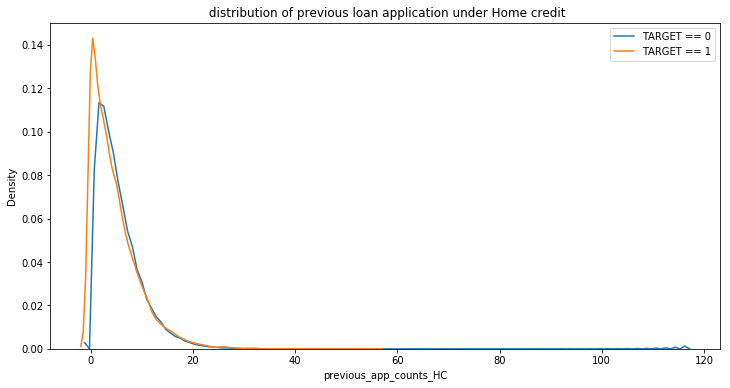

In [111]:
#https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check4.ix[X_train_check['TARGET'] == 0, "previous_app_counts"], label = 'TARGET == 0')
sns.kdeplot(X_train_check4.ix[X_train_check['TARGET'] == 1, "previous_app_counts"], label = 'TARGET == 1')
plt.xlabel("previous_app_counts_HC"); plt.ylabel('Density'); plt.title(" distribution of previous loan application under Home credit")
plt.legend()
plt.show()

#### Observation
    1. people who default on loans seem have fewer number of loan applications comparitively

### 6.2 Extraction of Numerical data

In [106]:
previous_aggregate = previous_application_1.drop(columns=['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False)\
                            .agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
columns = ['SK_ID_CURR']

for var in previous_aggregate.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in previous_aggregate.columns.levels[1][:-1]:
            columns.append('previous_application_%s_%s' % (var, stat))
previous_aggregate.columns = columns
previous_aggregate.head(3)

SK_ID_CURR  previous_application_AMT_ANNUITY_count  \
0      100001                                       1   
1      100002                                       1   
2      100003                                       3   

   previous_application_AMT_ANNUITY_mean  \
0                               3951.000   
1                               9251.775   
2                              56553.990   

   previous_application_AMT_ANNUITY_max  previous_application_AMT_ANNUITY_min  \
0                              3951.000                              3951.000   
1                              9251.775                              9251.775   
2                             98356.995                              6737.310   

   previous_application_AMT_ANNUITY_sum  \
0                              3951.000   
1                              9251.775   
2                            169661.970   

   previous_application_AMT_APPLICATION_count  \
0                                           1   
1                                           1   
2                                           3   

   previous_application_AMT_APPLICATION_mean  \
0                                    24835.5   
1                                   179055.0   
2                                   435436.5   

   previous_application_AMT_APPLICATION_max  \
0                                   24835.5   
1                                  179055.0   
2                                  900000.0   

   previous_application_AMT_APPLICATION_min  \
0                                   24835.5   
1                                  179055.0   
2                                   68809.5   

                          ...                          \
0                         ...                           
1                         ...                           
2                         ...                           

   previous_application_DAYS_TERMINATION_count  \
0                                            1   
1                                            1   
2                                            3   

   previous_application_DAYS_TERMINATION_mean  \
0                                -1612.000000   
1                                  -17.000000   
2                                -1047.333333   

   previous_application_DAYS_TERMINATION_max  \
0                                    -1612.0   
1                                      -17.0   
2                                     -527.0   

   previous_application_DAYS_TERMINATION_min  \
0                                    -1612.0   
1                                      -17.0   
2                                    -1976.0   

   previous_application_DAYS_TERMINATION_sum  \
0                                    -1612.0   
1                                      -17.0   
2                                    -3142.0   

   previous_application_NFLAG_INSURED_ON_APPROVAL_count  \
0                                                  1      
1                                                  1      
2                                                  3      

   previous_application_NFLAG_INSURED_ON_APPROVAL_mean  \
0                                           0.000000     
1                                           0.000000     
2                                           0.666667     

   previous_application_NFLAG_INSURED_ON_APPROVAL_max  \
0                                                0.0    
1                                                0.0    
2                                                1.0    

   previous_application_NFLAG_INSURED_ON_APPROVAL_min  \
0                                                0.0    
1                                                0.0    
2                                                0.0    

   previous_application_NFLAG_INSURED_ON_APPROVAL_sum  
0                                                0.0   
1                                                0.0   
2                            

In [107]:
X_train_check5=X_train_check4
X_test_check5=X_test_check4
X_cv_check5=X_cv_check4

X_train_check5 = X_train_check5.merge(previous_aggregate, on = 'SK_ID_CURR', how = 'left')
X_cv_check5 = X_cv_check5.merge(previous_aggregate, on = 'SK_ID_CURR', how = 'left')
X_test_check5 = X_test_check5.merge(previous_aggregate, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check5.shape)
print('The shape of cv data is ',X_cv_check5.shape)
print('The shape of testing data: ', X_test_check5.shape)

The shape of training data is :  (245997, 391)
The shape of cv data is  (30751, 391)
The shape of testing data:  (30752, 391)


#### EDA on extracted data

In [114]:
agg_correlation = []

# Iterate through the columns 
for column in columns:
    # Calculate correlation with the target
    correlation = X_train_check5['TARGET'].corr(X_train_check5[column])
    agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The correlation values obtained are as follows:")
agg_correlation[:5]   

The correlation values obtained are as follows:


[('previous_application_DAYS_DECISION_min', 0.05261683762598277),
 ('previous_application_DAYS_FIRST_DRAWING_mean', -0.05053613381198218),
 ('previous_application_DAYS_FIRST_DRAWING_min', -0.04656905447519688),
 ('previous_application_DAYS_DECISION_mean', 0.04612689475881818),
 ('previous_application_DAYS_FIRST_DRAWING_sum', -0.041564314142628164)]

#### Observation
    1. We shall explore the top 2 features using distribution plots.

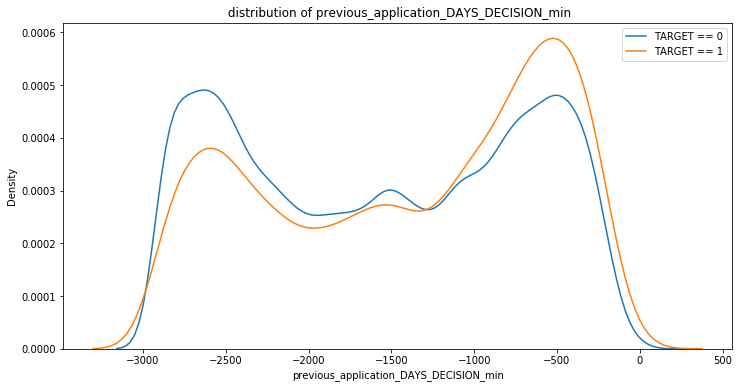

In [115]:
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check5.ix[X_train_check5['TARGET'] == 0, "previous_application_DAYS_DECISION_min"], label = 'TARGET == 0')
sns.kdeplot(X_train_check5.ix[X_train_check5['TARGET'] == 1, "previous_application_DAYS_DECISION_min"], label = 'TARGET == 1')
plt.xlabel("previous_application_DAYS_DECISION_min"); plt.ylabel('Density'); plt.title(" distribution of previous_application_DAYS_DECISION_min")
plt.legend()
plt.show()

#### Observation
    1. We can't say whether this data will be useful or not.

### 6.3 Feature optimization

In [108]:
X_train_check6,X_test_check6,X_cv_check6=column_optimization(X_train_check5, X_test_check5,X_cv_check5, threshold = 70)
print("Succefully removed columns with missing information greater than 70%")
print("="*50)
print("the shape of train data after optimisation is ", X_train_check6.shape)
print("the shape of test data after optimisation is ", X_test_check6.shape)
print("the shape of cv data after optimisation is ", X_cv_check6.shape)

There are 6 columns with greater than 70% missing values.
Succefully removed columns with missing information greater than 70%
the shape of train data after optimisation is  (245997, 385)
the shape of test data after optimisation is  (30752, 385)
the shape of cv data after optimisation is  (30751, 385)


In [109]:
X_train_check7,X_test_check7,X_cv_check7=collinear_removal(X_train_check6,X_test_check6,X_cv_check6,threshold=0.8)

100%|██████████████████████████████████████████████████████████████████████████████| 384/384 [00:00<00:00, 7329.46it/s]


These many columns will be removed:  76
The shape of train data after optimisation:  (245997, 309)
The shape of test data after optimisation:  (30752, 309)
The shape of cv data after optimisation:  (30751, 309)


### 6.4 Extraction of categorical data

In [110]:
categorical_data = pd.get_dummies(previous_application_1.select_dtypes('object'))
categorical_data['SK_ID_CURR'] = previous_application_1['SK_ID_CURR']
categorical_grouped = categorical_data.groupby('SK_ID_CURR', as_index=False).agg(['sum', 'mean']).reset_index()

group_var = 'SK_ID_CURR'

# Need to create new column names
columns = ['SK_ID_CURR']
#categorical_id= categorical_grouped['SK_ID_CURR']
#categorical_grouped=categorical_grouped.drop(['SK_ID_CURR'], axis=1)
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in categorical_grouped.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('Previous_application_%s_%s' % (var, stat))

categorical_grouped.columns = columns          
categorical_grouped.head(2)

SK_ID_CURR  Previous_application_NAME_CONTRACT_TYPE_Cash loans_sum  \
0      100001                                                  0        
1      100002                                                  0        

   Previous_application_NAME_CONTRACT_TYPE_Cash loans_mean  \
0                                                0.0         
1                                                0.0         

   Previous_application_NAME_CONTRACT_TYPE_Consumer loans_sum  \
0                                                  1            
1                                                  1            

   Previous_application_NAME_CONTRACT_TYPE_Consumer loans_mean  \
0                                                1.0             
1                                                1.0             

   Previous_application_NAME_CONTRACT_TYPE_Revolving loans_sum  \
0                                                  0             
1                                                  0             

   Previous_application_NAME_CONTRACT_TYPE_Revolving loans_mean  \
0                                                0.0              
1                                                0.0              

   Previous_application_NAME_CONTRACT_TYPE_XNA_sum  \
0                                                0   
1                                                0   

   Previous_application_NAME_CONTRACT_TYPE_XNA_mean  \
0                                               0.0   
1                                               0.0   

   Previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_sum  \
0                                                  1            
1                                                  0            

                                     ...                                      \
0                                    ...                                       
1                                    ...                                       

   Previous_application_PRODUCT_COMBINATION_POS industry without interest_sum  \
0                                                  0                            
1                                                  0                            

   Previous_application_PRODUCT_COMBINATION_POS industry without interest_mean  \
0                                                0.0                             
1                                                0.0                             

   Previous_application_PRODUCT_COMBINATION_POS mobile with interest_sum  \
0                                                  1                       
1                                                  0                       

   Previous_application_PRODUCT_COMBINATION_POS mobile with interest_mean  \
0                                                1.0                        
1                                                0.0                        

   Previous_application_PRODUCT_COMBINATION_POS mobile without interest_sum  \
0                                                  0                          
1                                                  0                          

   Previous_application_PRODUCT_COMBINATION_POS mobile without interest_mean  \
0                                                0.0                           
1                                                0.0                           

   Previous_application_PRODUCT_COMBINATION_POS other with interest_sum  \
0                                                  0                      
1                                                  1                      

   Previous_application_PRODUCT_COMBINATION_POS other with interest_mean  \
0                                                0.0                       
1                                                1.0                       

   Previous_application_PRODUCT_COMBINATION_POS others without interest_sum  \
0                                                  0                 

In [111]:
X_train_check8=X_train_check7
X_test_check8=X_test_check7
X_cv_check8=X_cv_check7

X_train_check8 = X_train_check8.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')
X_cv_check8 = X_cv_check8.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')
X_test_check8 = X_test_check8.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check8.shape)
print('The shape of cv data is ',X_cv_check8.shape)
print('The shape of testing data: ', X_test_check8.shape)

The shape of training data is :  (245997, 595)
The shape of cv data is  (30751, 595)
The shape of testing data:  (30752, 595)


In [118]:
#X_train_check4.to_csv('train_app.csv', index = False)
#X_test_check4.to_csv('test_app.csv', index = False)
#X_cv_check4.to_csv('cv_app.csv', index = False)
                                                            #CHECKPOINT
#X_train_check4=pd.read_csv("train_app")
#X_test_check4=pd.read_csv("test_app")
#X_cv_check4=pd.read_csv("cv_app")

#### EDA on extracted data

In [119]:
grouped_correlation = []

# Iterate through the columns 
for column in columns:
    # Calculate correlation with the target
    correlation = X_train_check8['TARGET'].corr(X_train_check8[column])
    grouped_correlation.append((column, correlation))
grouped_correlation = sorted(grouped_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The correlation values obtained are as follows:")
grouped_correlation[:5] 

The correlation values obtained are as follows:


[('Previous_application_NAME_CONTRACT_STATUS_Refused_mean',
  0.07822225062143298),
 ('Previous_application_CODE_REJECT_REASON_XAP_mean', -0.07424381305896897),
 ('Previous_application_NAME_CONTRACT_STATUS_Refused_sum',
  0.06408105167048259),
 ('Previous_application_NAME_CONTRACT_STATUS_Approved_mean',
  -0.06338318203614159),
 ('Previous_application_CODE_REJECT_REASON_SCOFR_sum', 0.056390589309529844)]

#### Observation
    1. We shall do eda on top features to see if we can up with any patterns.

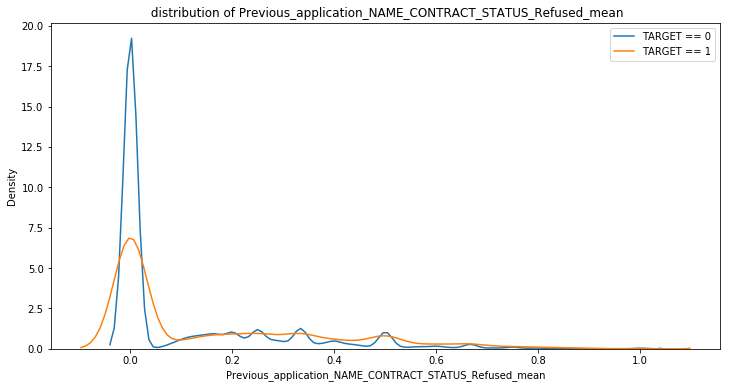

In [120]:
plt.figure(figsize = (12, 6))
sns.kdeplot(X_train_check8.ix[X_train_check8['TARGET'] == 0, "Previous_application_NAME_CONTRACT_STATUS_Refused_mean"], label = 'TARGET == 0')
sns.kdeplot(X_train_check8.ix[X_train_check8['TARGET'] == 1, "Previous_application_NAME_CONTRACT_STATUS_Refused_mean"], label = 'TARGET == 1')
plt.xlabel("Previous_application_NAME_CONTRACT_STATUS_Refused_mean"); plt.ylabel('Density'); plt.title(" distribution of Previous_application_NAME_CONTRACT_STATUS_Refused_mean")
plt.legend()
plt.show()

#### Observations
    1. It's hard to say if this will be useful in the future or not.

### 6.5 Feature optimisation

In [113]:
X_train_check9,X_test_check9,X_cv_check9=column_optimization(X_train_check8, X_test_check8,X_cv_check8, threshold = 70)
#print("Succefully removed columns with missing information greater than 70%")
print("="*50)
print("the shape of train data after optimisation is ", X_train_check9.shape)
print("the shape of test data after optimisation is ", X_test_check9.shape)
print("the shape of cv data after optimisation is ", X_cv_check9.shape)

There are 0 columns with greater than 70% missing values.
the shape of train data after optimisation is  (245997, 595)
the shape of test data after optimisation is  (30752, 595)
the shape of cv data after optimisation is  (30751, 595)


In [114]:
X_train_check10,X_test_check10,X_cv_check10=collinear_removal(X_train_check9,X_test_check9,X_cv_check9,threshold=0.8)

100%|█████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 16357.32it/s]


These many columns will be removed:  58
The shape of train data after optimisation:  (245997, 537)
The shape of test data after optimisation:  (30752, 537)
The shape of cv data after optimisation:  (30751, 537)


### 6.6 Feature extraction from POSH cash balance(Part of previous application data) 

In [115]:
categorical_data = pd.get_dummies(cash_balance_11.select_dtypes('object'))
categorical_data['SK_ID_PREV'] = cash_balance_11['SK_ID_PREV']
categorical_grouped = categorical_data.groupby('SK_ID_PREV', as_index=False).agg(['sum', 'mean']).reset_index()

group_var = 'SK_ID_PREV'

# Need to create new column names
columns_cat = ['SK_ID_PREV']
#categorical_id= categorical_grouped['SK_ID_CURR']
#categorical_grouped=categorical_grouped.drop(['SK_ID_CURR'], axis=1)
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in categorical_grouped.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns_cat.append('cash_balance_%s_%s' % (var, stat))

   #  Rename the columns
categorical_grouped.columns = columns_cat
#categorical_grouped['SK_ID_CURR'] = categorical_id 
categorical_grouped.SK_ID_PREV.astype(int)

numerical_grouped = cash_balance_11.groupby('SK_ID_PREV', as_index = False)\
                            .agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
columns_num = ['SK_ID_PREV']

for var in numerical_grouped.columns.levels[0]:
    if var != 'SK_ID_PREV':
        for stat in numerical_grouped.columns.levels[1][:-1]:
            columns_num.append('cash_balance_%s_%s' % (var, stat))
numerical_grouped.columns = columns_num
#print(numerical_grouped.columns)
bureau_balance_papplication = categorical_grouped.merge(numerical_grouped, on = 'SK_ID_PREV', how ="outer") 
print("the shape of categorical data ",categorical_grouped.shape,"+ numberical data "\
      ,numerical_grouped.shape,"in final merge which is our aggregated cash balance\n data is"\
      ,bureau_balance_papplication.shape)

bureau_papplication = previous_application_1[['SK_ID_PREV', 'SK_ID_CURR']].merge(bureau_balance_papplication, on = 'SK_ID_PREV', how = 'left')
print("the shape of final previous application data after including required client ids is ",bureau_papplication.shape)

bureau_papplication=bureau_papplication.drop(['SK_ID_PREV'],axis=1)
bureau_papplication.rename(columns={'SK_ID_CURR_x':'SK_ID_CURR'}, inplace=True)
print("The shape of data after dropping  SK_ID_PREV id is ",bureau_papplication.shape)

bureau_papplication = bureau_papplication.groupby('SK_ID_CURR', as_index=False).count()
print("the shape of final previous application data after aggregation is ",bureau_papplication.shape)

bureau_papplication.head(2)

the shape of categorical data  (936325, 19) + numberical data  (936325, 31) in final merge which is our aggregated cash balance
 data is (936325, 49)
the shape of final previous application data after including required client ids is  (1670214, 50)
The shape of data after dropping  SK_ID_PREV id is  (1670214, 49)
the shape of final previous application data after aggregation is  (338857, 49)


SK_ID_CURR  cash_balance_NAME_CONTRACT_STATUS_Active_sum  \
0      100001                                             1   
1      100002                                             1   

   cash_balance_NAME_CONTRACT_STATUS_Active_mean  \
0                                              1   
1                                              1   

   cash_balance_NAME_CONTRACT_STATUS_Amortized debt_sum  \
0                                                  1      
1                                                  1      

   cash_balance_NAME_CONTRACT_STATUS_Amortized debt_mean  \
0                                                  1       
1                                                  1       

   cash_balance_NAME_CONTRACT_STATUS_Approved_sum  \
0                                               1   
1                                               1   

   cash_balance_NAME_CONTRACT_STATUS_Approved_mean  \
0                                                1   
1                                                1   

   cash_balance_NAME_CONTRACT_STATUS_Canceled_sum  \
0                                               1   
1                                               1   

   cash_balance_NAME_CONTRACT_STATUS_Canceled_mean  \
0                                                1   
1                                                1   

   cash_balance_NAME_CONTRACT_STATUS_Completed_sum  \
0                                                1   
1                                                1   

              ...               cash_balance_SK_DPD_count  \
0             ...                                       1   
1             ...                                       1   

   cash_balance_SK_DPD_mean  cash_balance_SK_DPD_max  cash_balance_SK_DPD_min  \
0                         1                        1                        1   
1                         1                        1                        1   

   cash_balance_SK_DPD_sum  cash_balance_SK_DPD_DEF_count  \
0                        1                              1   
1                        1                              1   

   cash_balance_SK_DPD_DEF_mean  cash_balance_SK_DPD_DEF_max  \
0                             1                            1   
1                             1                            1   

   cash_balance_SK_DPD_DEF_min  cash_balance_SK_DPD_DEF_sum  
0                            1                            1  
1                            1                            1  

[2 rows x 49 columns]

In [117]:
X_train_check11=X_train_check10
X_cv_check11=X_cv_check10
X_test_check11=X_test_check10
X_train_check11 = X_train_check11.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_cv_check11 = X_cv_check11.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_test_check11 = X_test_check11.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check11.shape)
print('The shape of cv data is ',X_cv_check11.shape)
print('The shape of testing data: ', X_test_check11.shape)

The shape of training data is :  (245997, 585)
The shape of cv data is  (30751, 585)
The shape of testing data:  (30752, 585)


#### EDA on categorical data

In [123]:
agg_correlation = []

# Iterate through the columns 
for column in columns_cat:
    if column!='SK_ID_PREV':
    # Calculate correlation with the target
        correlation = X_train_check11['TARGET'].corr(X_train_check11[column])
        agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The coreelation values obtained for categorical data are as follows:")
agg_correlation[:5]  

The coreelation values obtained for categorical data are as follows:


[('cash_balance_NAME_CONTRACT_STATUS_Active_sum', -0.03853548818513951),
 ('cash_balance_NAME_CONTRACT_STATUS_Active_mean', -0.03853548818513951),
 ('cash_balance_NAME_CONTRACT_STATUS_Amortized debt_sum',
  -0.03853548818513951),
 ('cash_balance_NAME_CONTRACT_STATUS_Amortized debt_mean',
  -0.03853548818513951),
 ('cash_balance_NAME_CONTRACT_STATUS_Approved_sum', -0.03853548818513951)]

#### Observation
    1. We find that the data is weakly correlated.

#### EDA on numerical data

In [124]:
agg_correlation = []

# Iterate through the columns 
for column in columns_num:
    if column!='SK_ID_PREV':
    # Calculate correlation with the target
        correlation = X_train_check11['TARGET'].corr(X_train_check11[column])
        agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The coreelation values obtained for categorical data are as follows:")
agg_correlation[:5]  

The coreelation values obtained for categorical data are as follows:


[('cash_balance_CNT_INSTALMENT_mean', -0.03872719468358886),
 ('cash_balance_CNT_INSTALMENT_max', -0.03872719468358886),
 ('cash_balance_CNT_INSTALMENT_min', -0.03872719468358886),
 ('cash_balance_CNT_INSTALMENT_FUTURE_mean', -0.03872719468358886),
 ('cash_balance_CNT_INSTALMENT_FUTURE_max', -0.03872719468358886)]

#### Observation
    1. We find that the data is weakly correlated.

In [125]:
#X_train_check5.to_csv('train_app1.csv', index = False)
#X_test_check5.to_csv('test_app1.csv', index = False)
#X_cv_check5.to_csv('cv_app1.csv', index = False)
#Y_train.to_csv("Y_train_final",index=False)
#Y_test.to_csv("Y_test_final",index=False)
#Y_cv.to_csv("Y_cv_final",index=False)
#X_train_check5=pd.read_csv("train_app1.csv")
#X_test_check5=pd.read_csv("test_app1.csv")
#X_cv_check5=pd.read_csv("cv_app1.csv")

### 6.7 Feature optimization

In [121]:
X_train_check12,X_test_check12,X_cv_check12=column_optimization(X_train_check11, X_test_check11,X_cv_check11, threshold = 70)
#print("Succefully removed columns with missing information greater than 70%")
print("="*50)
print("the shape of train data after optimisation is ", X_train_check12.shape)
print("the shape of test data after optimisation is ", X_test_check12.shape)
print("the shape of cv data after optimisation is ", X_cv_check12.shape)
X_train_check13,X_test_check13,X_cv_check13=collinear_removal(X_train_check12,X_test_check12,X_cv_check12,threshold=0.8)

There are 0 columns with greater than 70% missing values.
the shape of train data after optimisation is  (245997, 585)
the shape of test data after optimisation is  (30752, 585)
the shape of cv data after optimisation is  (30751, 585)


100%|█████████████████████████████████████████████████████████████████████████████| 584/584 [00:00<00:00, 11677.28it/s]


These many columns will be removed:  48
The shape of train data after optimisation:  (245997, 537)
The shape of test data after optimisation:  (30752, 537)
The shape of cv data after optimisation:  (30751, 537)


### 6.8 Feature extraction from installments table(Part of previous application data) 

In [119]:
numerical_grouped = installments_12.groupby('SK_ID_PREV', as_index = False)\
                            .agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
columns_num = ['SK_ID_PREV']

for var in numerical_grouped.columns.levels[0]:
    if var != 'SK_ID_PREV':
        for stat in numerical_grouped.columns.levels[1][:-1]:
            columns_num.append('installments_%s_%s' % (var, stat))
numerical_grouped.columns = columns_num
#print(numerical_grouped.columns)
#bureau_balance_papplication = categorical_grouped.merge(numerical_grouped, on = 'SK_ID_PREV', how ="outer") 
print("the shape of categorical data numberical data ", numerical_grouped.shape)\
#      ,numerical_grouped.shape,"in final merge which is our aggregated bureau\n balance data is"\
#      ,bureau_balance_papplication.shape)

bureau_papplication = previous_application_1[['SK_ID_PREV', 'SK_ID_CURR']].merge(numerical_grouped, on = 'SK_ID_PREV', how = 'left')
print("the shape of final previous application data after including required client ids is ",bureau_papplication.shape)

bureau_papplication=bureau_papplication.drop(['SK_ID_PREV'],axis=1)
bureau_papplication.rename(columns={'SK_ID_CURR_x':'SK_ID_CURR'}, inplace=True)
print("The shape of data after dropping  SK_ID_PREV is ",bureau_papplication.shape)

bureau_papplication = bureau_papplication.groupby('SK_ID_CURR', as_index=False).count()
print("the shape of final previous application data after aggregation is ",bureau_papplication.shape)

bureau_papplication.head(2)

the shape of categorical data numberical data  (997752, 36)
the shape of final previous application data after including required client ids is  (1670214, 37)
The shape of data after dropping  SK_ID_PREV is  (1670214, 36)
the shape of final previous application data after aggregation is  (338857, 36)


SK_ID_CURR  installments_SK_ID_CURR_count  installments_SK_ID_CURR_mean  \
0      100001                              1                             1   
1      100002                              1                             1   

   installments_SK_ID_CURR_max  installments_SK_ID_CURR_min  \
0                            1                            1   
1                            1                            1   

   installments_SK_ID_CURR_sum  installments_NUM_INSTALMENT_VERSION_count  \
0                            1                                          1   
1                            1                                          1   

   installments_NUM_INSTALMENT_VERSION_mean  \
0                                         1   
1                                         1   

   installments_NUM_INSTALMENT_VERSION_max  \
0                                        1   
1                                        1   

   installments_NUM_INSTALMENT_VERSION_min              ...               \
0                                        1              ...                
1                                        1              ...                

   installments_AMT_INSTALMENT_count  installments_AMT_INSTALMENT_mean  \
0                                  1                                 1   
1                                  1                                 1   

   installments_AMT_INSTALMENT_max  installments_AMT_INSTALMENT_min  \
0                                1                                1   
1                                1                                1   

   installments_AMT_INSTALMENT_sum  installments_AMT_PAYMENT_count  \
0                                1                               1   
1                                1                               1   

   installments_AMT_PAYMENT_mean  installments_AMT_PAYMENT_max  \
0                              1                             1   
1                              1                             1   

   installments_AMT_PAYMENT_min  installments_AMT_PAYMENT_sum  
0                             1                             1  
1                             1                             1  

[2 rows x 36 columns]

In [122]:
X_train_check14=X_train_check13
X_cv_check14=X_cv_check13
X_test_check14=X_test_check13
X_train_check14 = X_train_check14.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_cv_check14 = X_cv_check14.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_test_check14 = X_test_check14.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check14.shape)
print('The shape of cv data is ',X_cv_check14.shape)
print('The shape of testing data: ', X_test_check14.shape)

The shape of training data is :  (245997, 572)
The shape of cv data is  (30751, 572)
The shape of testing data:  (30752, 572)


#### EDA on extracted data

In [126]:
agg_correlation = []

# Iterate through the columns 
for column in columns_num:
    if column!='SK_ID_PREV':
    # Calculate correlation with the target
        correlation = X_train_check14['TARGET'].corr(X_train_check14[column])
        agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The coreelation values obtained for numerical data are as follows:")
agg_correlation[:5]  

The coreelation values obtained for numerical data are as follows:


[('installments_DAYS_ENTRY_PAYMENT_mean', -0.028374049618544527),
 ('installments_DAYS_ENTRY_PAYMENT_max', -0.028374049618544527),
 ('installments_DAYS_ENTRY_PAYMENT_min', -0.028374049618544527),
 ('installments_AMT_PAYMENT_mean', -0.028374049618544527),
 ('installments_AMT_PAYMENT_max', -0.028374049618544527)]

#### Observations
    1. The data is very weakly correlated.

In [3]:
#X_train_check14.to_csv("X_train_check14.csv",index=False)
#X_test_check14.to_csv("X_test_check14.csv",index=False)
#X_cv_check14.to_csv("X_cv_check14.csv",index=False)

X_train_check14=pd.read_csv("X_train_check14.csv")
X_test_check14=pd.read_csv("X_test_check14.csv")
X_cv_check14=pd.read_csv("X_cv_check14.csv")

### 6.9 Feature optimization

In [8]:
X_train_check15,X_test_check15,X_cv_check15=column_optimization(X_train_check14, X_test_check14,X_cv_check14, threshold = 70)
#print("Succefully removed columns with missing information greater than 70%")
print("="*50)
print("the shape of train data after optimisation is ", X_train_check15.shape)
print("the shape of test data after optimisation is ", X_test_check15.shape)
print("the shape of cv data after optimisation is ", X_cv_check15.shape)
X_train_check16,X_test_check16,X_cv_check16=collinear_removal(X_train_check15,X_test_check15,X_cv_check15,threshold=0.8)

There are 0 columns with greater than 70% missing values.
the shape of train data after optimisation is  (245997, 572)
the shape of test data after optimisation is  (30752, 572)
the shape of cv data after optimisation is  (30751, 572)


100%|█████████████████████████████████████████████████████████████████████████████| 571/571 [00:00<00:00, 36547.90it/s]


These many columns will be removed:  35
The shape of train data after optimisation:  (245997, 537)
The shape of test data after optimisation:  (30752, 537)
The shape of cv data after optimisation:  (30751, 537)


### 6.10 Extracting features from Credit balance table(part of previous application data)

In [4]:
categorical_data = pd.get_dummies(credit_card_13.select_dtypes('object'))
categorical_data['SK_ID_PREV'] = credit_card_13['SK_ID_PREV']
categorical_grouped = categorical_data.groupby('SK_ID_PREV', as_index=False).agg(['sum', 'mean']).reset_index()

group_var = 'SK_ID_PREV'

# Need to create new column names
columns_cat = ['SK_ID_PREV']
#categorical_id= categorical_grouped['SK_ID_CURR']
#categorical_grouped=categorical_grouped.drop(['SK_ID_CURR'], axis=1)
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in categorical_grouped.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns_cat.append('credit_card_%s_%s' % (var, stat))

   #  Rename the columns
categorical_grouped.columns = columns_cat
#categorical_grouped['SK_ID_CURR'] = categorical_id 
categorical_grouped.SK_ID_PREV.astype(int)

numerical_grouped = credit_card_13.groupby('SK_ID_PREV', as_index = False)\
                            .agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
columns_num = ['SK_ID_PREV']

for var in numerical_grouped.columns.levels[0]:
    if var != 'SK_ID_PREV':
        for stat in numerical_grouped.columns.levels[1][:-1]:
            columns_num.append('credit_card_%s_%s' % (var, stat))
numerical_grouped.columns = columns_num
#print(numerical_grouped.columns)
bureau_balance_papplication = categorical_grouped.merge(numerical_grouped, on = 'SK_ID_PREV', how ="outer") 
print("the shape of categorical data ",categorical_grouped.shape,"+ numberical data "\
      ,numerical_grouped.shape,"in final merge which is our aggregated credit\n card data is"\
      ,bureau_balance_papplication.shape)

bureau_papplication = previous_application_1[['SK_ID_PREV', 'SK_ID_CURR']].merge(bureau_balance_papplication, on = 'SK_ID_PREV', how = 'left')
print("the shape of final credit card data after including required client ids is ",bureau_papplication.shape)

bureau_papplication=bureau_papplication.drop(['SK_ID_PREV'],axis=1)
bureau_papplication.rename(columns={'SK_ID_CURR_x':'SK_ID_CURR'}, inplace=True)
print("The shape of data after dropping  SK_IK_PREV is ",bureau_papplication.shape)

bureau_papplication = bureau_papplication.groupby('SK_ID_CURR', as_index=False).count()
print("the shape of final previous application data after aggregation is ",bureau_papplication.shape)

bureau_papplication.head(2)

the shape of categorical data  (104307, 15) + numberical data  (104307, 106) in final merge which is our aggregated credit
 card data is (104307, 120)
the shape of final credit card data after including required client ids is  (1670214, 121)
The shape of data after dropping  SK_IK_PREV is  (1670214, 120)
the shape of final previous application data after aggregation is  (338857, 120)


SK_ID_CURR  credit_card_NAME_CONTRACT_STATUS_Active_sum  \
0      100001                                            0   
1      100002                                            0   

   credit_card_NAME_CONTRACT_STATUS_Active_mean  \
0                                             0   
1                                             0   

   credit_card_NAME_CONTRACT_STATUS_Approved_sum  \
0                                              0   
1                                              0   

   credit_card_NAME_CONTRACT_STATUS_Approved_mean  \
0                                               0   
1                                               0   

   credit_card_NAME_CONTRACT_STATUS_Completed_sum  \
0                                               0   
1                                               0   

   credit_card_NAME_CONTRACT_STATUS_Completed_mean  \
0                                                0   
1                                                0   

   credit_card_NAME_CONTRACT_STATUS_Demand_sum  \
0                                            0   
1                                            0   

   credit_card_NAME_CONTRACT_STATUS_Demand_mean  \
0                                             0   
1                                             0   

   credit_card_NAME_CONTRACT_STATUS_Refused_sum             ...              \
0                                             0             ...               
1                                             0             ...               

   credit_card_SK_DPD_count  credit_card_SK_DPD_mean  credit_card_SK_DPD_max  \
0                         0                        0                       0   
1                         0                        0                       0   

   credit_card_SK_DPD_min  credit_card_SK_DPD_sum  \
0                       0                       0   
1                       0                       0   

   credit_card_SK_DPD_DEF_count  credit_card_SK_DPD_DEF_mean  \
0                             0                            0   
1                             0                            0   

   credit_card_SK_DPD_DEF_max  credit_card_SK_DPD_DEF_min  \
0                           0                           0   
1                           0                           0   

   credit_card_SK_DPD_DEF_sum  
0                           0  
1                           0  

[2 rows x 120 columns]

In [9]:
X_train_check17=X_train_check16
X_cv_check17=X_cv_check16
X_test_check17=X_test_check16
X_train_check17 = X_train_check17.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_cv_check17 = X_cv_check17.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')
X_test_check17 = X_test_check17.merge(bureau_papplication, on = 'SK_ID_CURR', how = 'left')

print('The shape of training data is : ', X_train_check17.shape)
print('The shape of cv data is ',X_cv_check17.shape)
print('The shape of testing data: ', X_test_check17.shape)

The shape of training data is :  (245997, 656)
The shape of cv data is  (30751, 656)
The shape of testing data:  (30752, 656)


#### EDA on categorical data

In [132]:
agg_correlation = []

# Iterate through the columns 
for column in columns_cat:
    if column!='SK_ID_PREV':
    # Calculate correlation with the target
        correlation = X_train_check17['TARGET'].corr(X_train_check17[column])
        agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The coreelation values obtained for categorical data are as follows:")
agg_correlation[:5] 

The coreelation values obtained for categorical data are as follows:


[('credit_card_NAME_CONTRACT_STATUS_Active_sum', 0.020133436333717284),
 ('credit_card_NAME_CONTRACT_STATUS_Active_mean', 0.020133436333717284),
 ('credit_card_NAME_CONTRACT_STATUS_Approved_sum', 0.020133436333717284),
 ('credit_card_NAME_CONTRACT_STATUS_Approved_mean', 0.020133436333717284),
 ('credit_card_NAME_CONTRACT_STATUS_Completed_sum', 0.020133436333717284)]

#### Eda on numerical data

In [133]:
agg_correlation = []

# Iterate through the columns 
for column in columns_num:
    if column!='SK_ID_PREV':
    # Calculate correlation with the target
        correlation = X_train_check17['TARGET'].corr(X_train_check17[column])
        agg_correlation.append((column, correlation))
agg_correlation = sorted(agg_correlation, key = lambda x: abs(x[1]), reverse = True)
print("The corelation values obtained for numerical data are as follows:")
agg_correlation[:5] 

The corelation values obtained for numerical data are as follows:


[('credit_card_AMT_DRAWINGS_ATM_CURRENT_mean', 0.04587154015926001),
 ('credit_card_AMT_DRAWINGS_ATM_CURRENT_max', 0.04587154015926001),
 ('credit_card_AMT_DRAWINGS_ATM_CURRENT_min', 0.04587154015926001),
 ('credit_card_AMT_DRAWINGS_OTHER_CURRENT_mean', 0.04587154015926001),
 ('credit_card_AMT_DRAWINGS_OTHER_CURRENT_max', 0.04587154015926001)]

#### Observations
    1. We find that the data is correlated to some extent

### 6.11 Feature optimization

In [10]:
X_train_check18,X_test_check18,X_cv_check18=column_optimization(X_train_check17, X_test_check17,X_cv_check17, threshold = 70)
#print("Succefully removed columns with missing information greater than 70%")
print("="*50)
print("the shape of train data after optimisation is ", X_train_check18.shape)
print("the shape of test data after optimisation is ", X_test_check18.shape)
print("the shape of cv data after optimisation is ", X_cv_check18.shape)
X_train_check19,X_test_check19,X_cv_check19=collinear_removal(X_train_check18,X_test_check18,X_cv_check18,threshold=0.8)

There are 0 columns with greater than 70% missing values.
the shape of train data after optimisation is  (245997, 656)
the shape of test data after optimisation is  (30752, 656)
the shape of cv data after optimisation is  (30751, 656)


100%|██████████████████████████████████████████████████████████████████████████████| 655/655 [00:00<00:00, 5989.60it/s]


These many columns will be removed:  118
The shape of train data after optimisation:  (245997, 538)
The shape of test data after optimisation:  (30752, 538)
The shape of cv data after optimisation:  (30751, 538)


## 7 Saving the optimized feature extracted data 

In [11]:
X_train_check19.to_csv('train_extracted_final.csv', index = False)
X_test_check19.to_csv('test_extracted_final.csv', index = False)
X_cv_check19.to_csv('cv_extracted_final.csv', index = False)
#Y_train.to_csv("Y_train_final",index=False)
#Y_test.to_csv("Y_test_final",index=False)
#Y_cv.to_csv("Y_cv_final",index=False)


#X_train_check5=pd.read_csv("train_app1.csv")
#X_test_check5=pd.read_csv("test_app1.csv")
#X_cv_check5=pd.read_csv("cv_app1.csv")